In [1]:
from numba.core.extending import get_cython_function_address
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import pytz
import pvlib

# directory with clean and organized data per year for GHI, GTI, DIF, DNI
main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/CLEAN/" 

# directory to save BSRN test results
BSRN_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/BSRNminGTI/" 


gti = ['TGHIP_SI02pt100', 
       'TGHIP_SI02pt100_dirty',
       'TGIP_SMP11_VENT']
      


fgti = ['F_TGHIP_SI02pt100', 
        'F_TGHIP_SI02pt100_dirty', 
        'F_TGIP_SMP11_VENT']

surface_tilt = 27

surface_azimuth = 0 # @south hemisphere facing north

months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
          '2021-01']

years = ['2018', '2019', '2020', '2021']
#years = ['2019', '2020', '2021']
#years = ['2020', '2021']



#BSRN TEST

# latitude, longitude, name, altitude, timezone - data retrieved in ETC/GMT - as plotted = noon around 3 pm
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Etc/GMT', altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'Brazil/East' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

#PPmin = -4  # minimum physically possible limit
#ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
         -1, #-9999   - apparently did not appear?!?! TEST: create specific flag to track it.
          3, # too low PP
          4] # too high PP

gtiflagcount = pd.DataFrame(columns= [gti], index = [-1, 0, 3, 4], dtype = int) 


#### end definitions


In [2]:
year = years[0]

In [3]:
year

'2018'

In [4]:
    gtiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 
                                      'F_TGHIP_SI02pt100','F_TGHIP_SI02pt100_dirty', 
                                      'F_TGIP_SMP11_VENT'])
    
    dfgti = pd.read_pickle(main_path+year+'GTI.pkl')
    dfgti = dfgti.resample('1Min').mean()  
    print('dfgti.shape =', dfgti.shape,year)

    dfgti.index = dfgti.index.tz_localize(location.tz)
    
    naive_times = pd.date_range(start = dfgti.index.min(), end = dfgti.index.max(), freq='1Min', tz = location.tz)
    naive_times = pd.DatetimeIndex(naive_times)   # PROBLEM: WILL HAVE TO DEAL WITH MISSING VALUES
    print('NAIVE.shape =', naive_times.shape,year)

    missing.loc[year] = (len(naive_times) - len(dfgti.index))/3600/24

    eth = pvlib.irradiance.get_extra_radiation(naive_times, solar_constant = 1366.1, method = 'nrel').to_frame()
    solpos = pvlib.solarposition.get_solarposition(naive_times, location.latitude, location.longitude, location.altitude, pressure = 101293, temperature = 25)
    print('linha83')

    aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos.zenith, solpos.azimuth)

dfgti.shape = (525201, 3) 2018
NAIVE.shape = (525201,) 2018
linha83


In [10]:
aoi

2018-01-01 00:00:00+00:00    126.695687
2018-01-01 00:01:00+00:00    126.912990
2018-01-01 00:02:00+00:00    127.130089
2018-01-01 00:03:00+00:00    127.346981
2018-01-01 00:04:00+00:00    127.563664
                                ...    
2018-12-31 17:16:00+00:00     36.735936
2018-12-31 17:17:00+00:00     36.927227
2018-12-31 17:18:00+00:00     37.119111
2018-12-31 17:19:00+00:00     37.311579
2018-12-31 17:20:00+00:00     37.504621
Freq: T, Name: aoi, Length: 525201, dtype: float64

In [7]:
solpos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2018-01-01 00:00:00+00:00,110.663146,110.663146,-20.663146,-20.663146,228.196556,-3.326452
2018-01-01 00:01:00+00:00,110.828313,110.828313,-20.828313,-20.828313,228.025374,-3.326779
2018-01-01 00:02:00+00:00,110.993036,110.993036,-20.993036,-20.993036,227.853515,-3.327106
2018-01-01 00:03:00+00:00,111.157312,111.157312,-21.157312,-21.157312,227.680976,-3.327434
2018-01-01 00:04:00+00:00,111.321138,111.321138,-21.321138,-21.321138,227.507754,-3.327761
...,...,...,...,...,...,...
2018-12-31 17:16:00+00:00,27.225043,27.233321,62.774957,62.766679,272.527550,-3.062259
2018-12-31 17:17:00+00:00,27.446600,27.454958,62.553400,62.545042,272.394111,-3.062590
2018-12-31 17:18:00+00:00,27.668178,27.676616,62.331822,62.323384,272.261829,-3.062921
2018-12-31 17:19:00+00:00,27.889777,27.898294,62.110223,62.101706,272.130675,-3.063252


In [5]:
cosaoi = np.cos(np.deg2rad(aoi)).to_frame()

In [12]:
cosaoi

,aoi
2018-01-01 00:00:00+00:00,-0.597565
2018-01-01 00:01:00+00:00,-0.600602
2018-01-01 00:02:00+00:00,-0.603627
2018-01-01 00:03:00+00:00,-0.606640
2018-01-01 00:04:00+00:00,-0.609643
...,...
2018-12-31 17:16:00+00:00,0.801401
2018-12-31 17:17:00+00:00,0.799399
2018-12-31 17:18:00+00:00,0.797383
2018-12-31 17:19:00+00:00,0.795351


In [6]:
    cosSZA = np.cos(np.deg2rad(solpos.zenith)).to_frame()


In [14]:
cosSZA

,zenith
2018-01-01 00:00:00+00:00,-0.352873
2018-01-01 00:01:00+00:00,-0.355569
2018-01-01 00:02:00+00:00,-0.358254
2018-01-01 00:03:00+00:00,-0.360930
2018-01-01 00:04:00+00:00,-0.363595
...,...
2018-12-31 17:16:00+00:00,0.889150
2018-12-31 17:17:00+00:00,0.887374
2018-12-31 17:18:00+00:00,0.885583
2018-12-31 17:19:00+00:00,0.883780


In [7]:
    gtiFLAG['PPmax'] = eth[0]*(cosaoi.aoi + (cosSZA.zenith**(1.2))) + 150


In [9]:
    gtiFLAG['PPmin'] = (-4)*(cosaoi.aoi + 2)


In [10]:
gtiFLAG

,PPmax,PPmin,F_TGHIP_SI02pt100,F_TGHIP_SI02pt100_dirty,F_TGIP_SMP11_VENT
2018-01-01 00:00:00+00:00,NaN,-5.609741,NaN,NaN,NaN
2018-01-01 00:01:00+00:00,NaN,-5.597594,NaN,NaN,NaN
2018-01-01 00:02:00+00:00,NaN,-5.585493,NaN,NaN,NaN
2018-01-01 00:03:00+00:00,NaN,-5.573438,NaN,NaN,NaN
2018-01-01 00:04:00+00:00,NaN,-5.561430,NaN,NaN,NaN
...,...,...,...,...,...
2018-12-31 17:16:00+00:00,2509.327518,-11.205603,NaN,NaN,NaN
2018-12-31 17:17:00+00:00,2503.557918,-11.197597,NaN,NaN,NaN
2018-12-31 17:18:00+00:00,2497.745823,-11.189531,NaN,NaN,NaN
2018-12-31 17:19:00+00:00,2491.891373,-11.181404,NaN,NaN,NaN


In [12]:
    gtiFLAG = pd.merge(gtiFLAG, dfgti, left_index = True, right_index = True, how = 'outer')  # index by naive times. how = 'inner': index by recorded times.
    print('MERGE gtiFLAG.shape =', gtiFLAG.shape,year)
    print('linha99')
    for column in gti:
        conditions = [gtiFLAG[column].isna(), 
                      gtiFLAG[column]== -9999, 
                      gtiFLAG[column] < gtiFLAG['PPmin'],
                      gtiFLAG[column] > gtiFLAG['PPmax']]
        flagcolumn = 'F_'+column
        gtiFLAG[flagcolumn] = np.select(conditions, flags, 0)
        gtiflagcount[column]= gtiFLAG[flagcolumn].value_counts()

MERGE gtiFLAG.shape = (525201, 8) 2018
linha99


In [13]:
gtiFLAG

,PPmax,PPmin,F_TGHIP_SI02pt100,F_TGHIP_SI02pt100_dirty,F_TGIP_SMP11_VENT,TGHIP_SI02pt100,TGHIP_SI02pt100_dirty,TGIP_SMP11_VENT
2018-01-01 00:00:00+00:00,NaN,-5.609741,0,0,0,0.000983,0.000000,-0.823333
2018-01-01 00:01:00+00:00,NaN,-5.597594,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:02:00+00:00,NaN,-5.585493,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:03:00+00:00,NaN,-5.573438,0,0,0,0.000000,0.000000,-0.890000
2018-01-01 00:04:00+00:00,NaN,-5.561430,0,0,0,0.000983,0.000000,-1.105000
...,...,...,...,...,...,...,...,...
2018-12-31 17:16:00+00:00,2509.327518,-11.205603,0,0,0,823.016667,832.416667,854.533333
2018-12-31 17:17:00+00:00,2503.557918,-11.197597,0,0,0,803.428333,812.798333,835.288333
2018-12-31 17:18:00+00:00,2497.745823,-11.189531,0,0,0,839.900000,849.333333,870.616667
2018-12-31 17:19:00+00:00,2491.891373,-11.181404,0,0,0,780.556667,789.781667,811.420000


<AxesSubplot:>

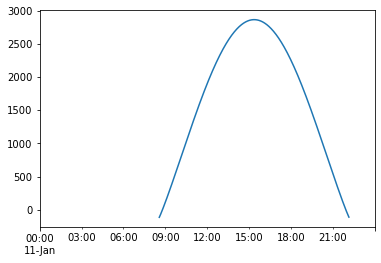

In [19]:
gtiFLAG.PPmax.loc['2018-01-11'].plot()

<AxesSubplot:>

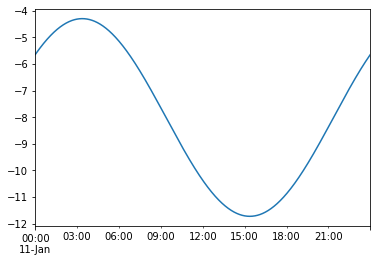

In [20]:
gtiFLAG.PPmin.loc['2018-01-11'].plot()

In [21]:
BSRN_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/BSRNminGTI/"

figs_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/figs/"



sensors =  [['TGHIP_SI02pt100', 
             'TGHIP_SI02pt100_dirty',
             'TGIP_SMP11_VENT']]


solar_constant = 1366.1


#months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
#          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
#          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
#          '2021-01']

years = ['2018', '2019', '2020', '2021']

dfgti = pd.DataFrame(columns = sensors)

In [22]:
year 

'2018'

In [23]:
    dfgti = pd.read_pickle(BSRN_path + year +'gtiFLAG.pkl')


In [24]:
dfgti

,PPmax,PPmin,F_TGHIP_SI02pt100,F_TGHIP_SI02pt100_dirty,F_TGIP_SMP11_VENT,TGHIP_SI02pt100,TGHIP_SI02pt100_dirty,TGIP_SMP11_VENT
2018-01-01 00:00:00+00:00,NaN,-5.609741,0,0,0,0.000983,0.000000,-0.823333
2018-01-01 00:01:00+00:00,NaN,-5.597594,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:02:00+00:00,NaN,-5.585493,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:03:00+00:00,NaN,-5.573438,0,0,0,0.000000,0.000000,-0.890000
2018-01-01 00:04:00+00:00,NaN,-5.561430,0,0,0,0.000983,0.000000,-1.105000
...,...,...,...,...,...,...,...,...
2018-12-31 17:16:00+00:00,2509.327518,-11.205603,0,0,0,823.016667,832.416667,854.533333
2018-12-31 17:17:00+00:00,2503.557918,-11.197597,0,0,0,803.428333,812.798333,835.288333
2018-12-31 17:18:00+00:00,2497.745823,-11.189531,0,0,0,839.900000,849.333333,870.616667
2018-12-31 17:19:00+00:00,2491.891373,-11.181404,0,0,0,780.556667,789.781667,811.420000


In [25]:
sensors =  [['TGHIP_SI02pt100', 
             'TGHIP_SI02pt100_dirty',
             'TGIP_SMP11_VENT']]


solar_constant = 1366.1


In [28]:
sensors =  ['TGHIP_SI02pt100', 
             'TGHIP_SI02pt100_dirty',
             'TGIP_SMP11_VENT']

In [30]:
sensor = sensors[0]

In [31]:
sensor

'TGHIP_SI02pt100'

               gti  flag
count    23.000000  23.0
mean   1401.818172   0.0
std      30.768677   0.0
min    1371.700000   0.0
25%    1377.451515   0.0
50%    1391.850000   0.0
75%    1418.962571   0.0
max    1483.885246   0.0


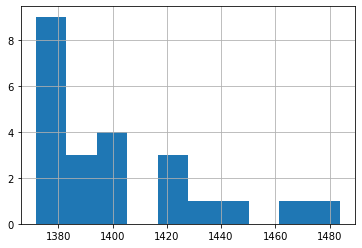

In [36]:
   
       dfGTI = pd.DataFrame(columns = ['gti', 'flag','delta', 'isstart', 'isend'])
       oie = pd.DataFrame(columns = ['gti', 'flag','delta', 'isstart', 'isend'])

       dfGTI['gti']  = dfgti[sensor]
       dfGTI['flag'] = dfgti['F_'+ sensor]
       dfGTI   = dfGTI[dfGTI.flag < 4]

       oie  = dfGTI[dfGTI['gti'] > solar_constant]   
       
       dfstat = oie.describe()
       dfstat.to_csv(BSRN_path + year + sensor + '_statsmin.csv')

       print(dfstat)
       gtihist = oie.gti.hist()
       gfigname = figs_path + year + 'gti_OIEmin_'+ sensor +'.jpeg'
       fig = gtihist.get_figure()
       #fig.savefig(gfigname)
       #fig.clf()
       
       
      

In [43]:
       oie.loc[:,'delta'] = oie.index.to_series().diff()/np.timedelta64(1,"m")  #FOR SECONDS MUST CHANGE HERE
       oie.iloc[0,2] = 1.1
       oie.loc[:,'isstart'] = (oie.delta > 1 )
       oie.loc[:,'isend'] = oie.isstart.shift(-1)
       oie.iloc[-1,4] = True

       
       # Table with all OIEE - Criteria 2
       
       eventsC2 = pd.DataFrame(columns = ['start', 'end', 'duration', 'ibe', 'min', 'max', 'avg'])     ### WILL NEED KT  TOO IN THIS SUMMARY!!!
       eventsC2['start']    = oie.loc[oie.isstart == True].index
       eventsC2['end']      = oie.loc[oie.isend == True].index
       eventsC2['duration'] = eventsC2.end  - eventsC2.start
       eventsC2['ibe']      = eventsC2.start - eventsC2.start.shift(+1)
       df1 = eventsC2.loc[:,'start': 'end']
       df2 = pd.DataFrame(columns = ['gti'])
       df2['gti']  = oie['gti']
       df1['list'] = df1.apply(lambda x : pd.date_range(start =x['start'],end=x['end'],freq='min').tolist(),axis=1)  ###  FOR SECONDS MUST CHANGE HERE
       df1 = df1['list'].apply(pd.Series).stack().to_frame().rename(columns={0:'Date'})
       df1['value'] = df1.Date.map(df2.gti)
       avg = df1.groupby(level=0).mean()
       min = df1.groupby(level=0).min()
       max = df1.groupby(level=0).max()
       eventsC2['avg'] = avg['value']
       eventsC2['min'] = min['value']
       eventsC2['max'] = max['value']
       #eventsC2.to_csv(BSRN_path + year + sensor + '_OIEC2min.csv')

       
  

/Users/nataly/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/nataly/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/nataly/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [44]:
eventsC2

,start,end,duration,ibe,min,max,avg
0,2018-01-11 15:48:00+00:00,2018-01-11 15:48:00+00:00,0 days 00:00:00,NaT,1388.100000,1388.100000,1388.100000
1,2018-01-11 15:54:00+00:00,2018-01-11 15:55:00+00:00,0 days 00:01:00,0 days 00:06:00,1378.266667,1424.916667,1401.591667
2,2018-01-11 16:02:00+00:00,2018-01-11 16:02:00+00:00,0 days 00:00:00,0 days 00:08:00,1390.516667,1390.516667,1390.516667
3,2018-01-15 16:07:00+00:00,2018-01-15 16:07:00+00:00,0 days 00:00:00,4 days 00:05:00,1373.866667,1373.866667,1373.866667
4,2018-02-14 15:35:00+00:00,2018-02-14 15:35:00+00:00,0 days 00:00:00,29 days 23:28:00,1483.885246,1483.885246,1483.885246
5,2018-02-16 14:59:00+00:00,2018-02-16 14:59:00+00:00,0 days 00:00:00,1 days 23:24:00,1376.636364,1376.636364,1376.636364
6,2018-02-16 15:02:00+00:00,2018-02-16 15:04:00+00:00,0 days 00:02:00,0 days 00:03:00,1404.266667,1466.383333,1433.055556
7,2018-02-21 14:20:00+00:00,2018-02-21 14:20:00+00:00,0 days 00:00:00,4 days 23:18:00,1375.953125,1375.953125,1375.953125
8,2018-03-01 14:59:00+00:00,2018-03-01 14:59:00+00:00,0 days 00:00:00,8 days 00:39:00,1419.416667,1419.416667,1419.416667
9,2018-03-08 14:27:00+00:00,2018-03-08 14:28:00+00:00,0 days 00:01:00,6 days 23:28:00,1399.084746,1418.508475,1408.796610


In [39]:
dfgti

,PPmax,PPmin,F_TGHIP_SI02pt100,F_TGHIP_SI02pt100_dirty,F_TGIP_SMP11_VENT,TGHIP_SI02pt100,TGHIP_SI02pt100_dirty,TGIP_SMP11_VENT
2018-01-01 00:00:00+00:00,NaN,-5.609741,0,0,0,0.000983,0.000000,-0.823333
2018-01-01 00:01:00+00:00,NaN,-5.597594,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:02:00+00:00,NaN,-5.585493,0,0,0,0.000000,0.000000,-0.800000
2018-01-01 00:03:00+00:00,NaN,-5.573438,0,0,0,0.000000,0.000000,-0.890000
2018-01-01 00:04:00+00:00,NaN,-5.561430,0,0,0,0.000983,0.000000,-1.105000
...,...,...,...,...,...,...,...,...
2018-12-31 17:16:00+00:00,2509.327518,-11.205603,0,0,0,823.016667,832.416667,854.533333
2018-12-31 17:17:00+00:00,2503.557918,-11.197597,0,0,0,803.428333,812.798333,835.288333
2018-12-31 17:18:00+00:00,2497.745823,-11.189531,0,0,0,839.900000,849.333333,870.616667
2018-12-31 17:19:00+00:00,2491.891373,-11.181404,0,0,0,780.556667,789.781667,811.420000


In [45]:
main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/INVERTER/"


column_names = ['TIMESTAMP',
                   'E_tot',
                   'V_grid',
                   'I_grid',
                   'P_grid',
                   'F_grid',
                   'P_in1',
                   'V_in1',
                   'I_in1',
                   'P_in2',
                   'V_in2',
                   'I_in2',
                   'T_inverter',
                   'T_booster',
                   'R_iso'] 

In [76]:
dfCDT  = pd.read_csv(main_path + 'CDT.csv')
dfCDTA  = pd.read_csv(main_path + 'CDTA.csv')
dfPSI  = pd.read_csv(main_path + 'PSI.csv')




In [47]:
dfCDT

,TIMESTAMP,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
0,2017-07-04 10:45:00,2193.921,234.6536,6.196396,1434.9640,59.98176,1479.3440,319.4513,4.700523,0.0,0,0,39.08350,33.51683,5.0
1,2017-07-04 10:46:00,2193.947,234.8455,6.196651,1439.2920,59.99952,1484.0010,319.8006,4.718031,0.0,0,0,39.08350,33.30969,5.0
2,2017-07-04 10:47:00,2193.972,234.7815,6.211050,1441.4260,60.00360,1486.0060,319.7704,4.747102,0.0,0,0,39.21859,33.41356,5.0
3,2017-07-04 10:48:00,2193.993,234.6642,6.275977,1450.1460,60.00192,1495.5130,320.0895,4.776174,0.0,0,0,39.24561,33.30969,5.0
4,2017-07-04 10:49:00,2194.021,234.4241,6.284834,1456.0430,59.98608,1501.0760,320.4254,4.810109,0.0,0,0,39.24561,33.15329,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828685,2021-02-11 15:09:00,13115.830,215.2951,2.661140,552.9396,59.97337,570.0408,311.8500,1.941638,0.0,0,0,44.47314,38.33249,5.0
1828686,2021-02-11 15:10:00,13115.840,215.6855,2.843410,590.6448,60.01645,608.0389,312.9937,2.030582,0.0,0,0,44.47314,38.43271,5.0
1828687,2021-02-11 15:11:00,13115.840,215.6725,2.846778,598.1732,60.00326,615.9943,313.4791,2.041984,0.0,0,0,44.40621,38.42018,5.0
1828688,2021-02-11 15:12:00,13115.860,215.6638,2.798108,597.4203,59.97649,615.8973,313.7646,2.058465,0.0,0,0,44.31250,38.33249,5.0


In [48]:
input1 = ['P_in1',
          'V_in1',
          'I_in1',]

<AxesSubplot:xlabel='TIMESTAMP'>

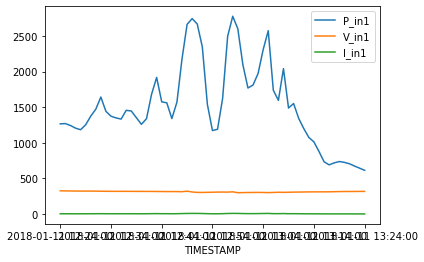

In [60]:
dfCDT[input1].loc['2018-01-11 12:24:00':'2018-01-11 13:24:00'].plot()

In [77]:
dfCDT = dfCDT.set_index('TIMESTAMP')
dfCDTA = dfCDTA.set_index('TIMESTAMP')
dfPSI = dfPSI.set_index('TIMESTAMP')

In [55]:
dfCDT.index

Index(['2017-07-04 10:45:00', '2017-07-04 10:46:00', '2017-07-04 10:47:00',
       '2017-07-04 10:48:00', '2017-07-04 10:49:00', '2017-07-04 10:50:00',
       '2017-07-04 10:51:00', '2017-07-04 10:52:00', '2017-07-04 10:53:00',
       '2017-07-04 10:54:00',
       ...
       '2021-02-11 15:04:00', '2021-02-11 15:05:00', '2021-02-11 15:06:00',
       '2021-02-11 15:07:00', '2021-02-11 15:08:00', '2021-02-11 15:09:00',
       '2021-02-11 15:10:00', '2021-02-11 15:11:00', '2021-02-11 15:12:00',
       '2021-02-11 15:13:00'],
      dtype='object', name='TIMESTAMP', length=1828690)

In [71]:
oiehigh = ['2018-01-11 12:54:00', '2019-01-12 11:11:00', '2020-12-24 13:10:00' ]


In [82]:
grid = ['V_grid',
        'I_grid',
        'P_grid',
        'F_grid']

AttributeError: 'list' object has no attribute 'type'

In [66]:
trinta = pd.Timedelta('30 min')


In [67]:
trinta

Timedelta('0 days 00:30:00')

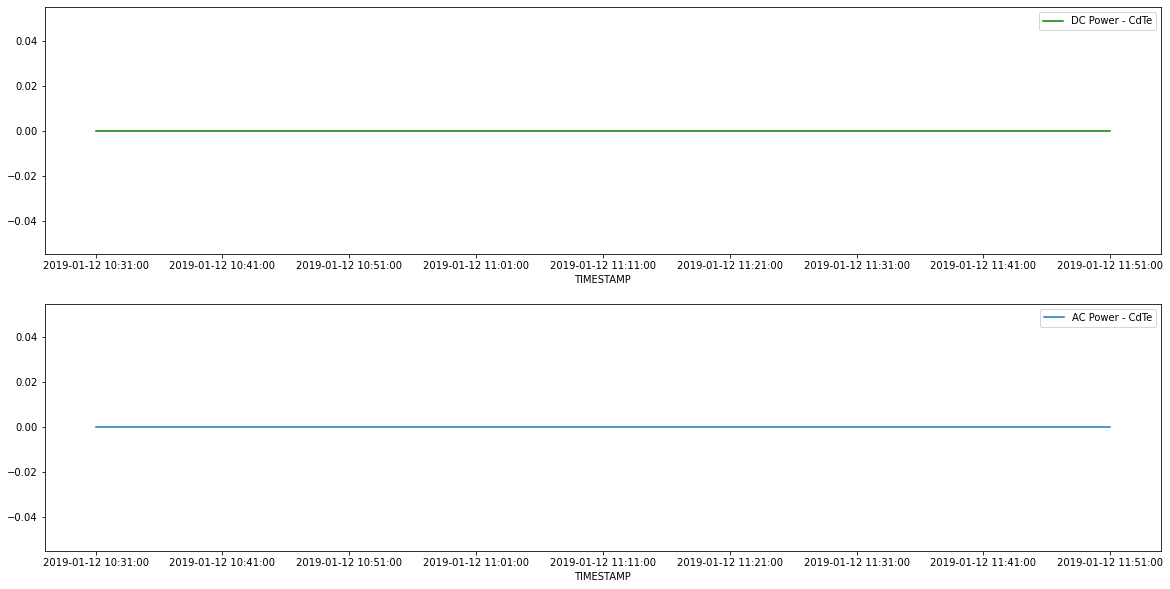

In [153]:

fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfCDT['P_in1'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTe')
#l1=axes[0].axhline(2750,color='red',ls='--')
#l1.set_label('Max Output')
axes[0].legend(loc='best')

f2= dfCDT['P_grid'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[1],label='AC Power - CdTe')
#l2=axes[1].axhline(2750,color='red',ls='--')
#l2.set_label('Max Output')
axes[1].legend(loc='best')

#f3 = dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[2],color = 'orange',label='GTI - SMP11')
#l3=axes[2].axhline(1366.1,color='red',ls='--')
#l3.set_label('Solar Constant')
#axes[2].legend(loc='best')



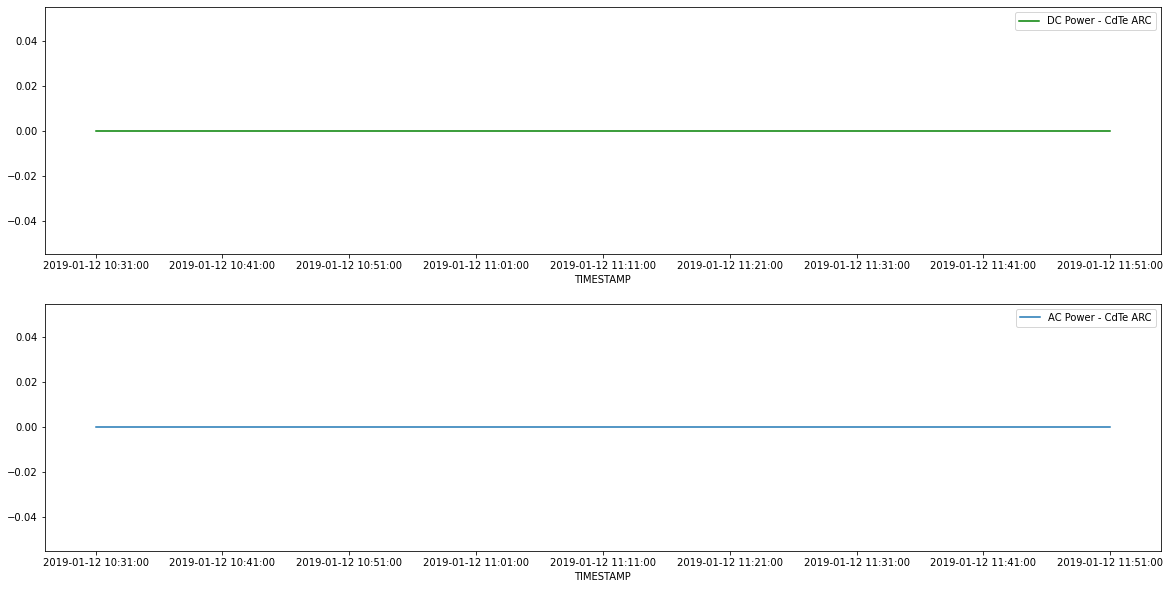

In [156]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfCDTA['P_in1'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTe ARC')
#l1=axes[0].axhline(2750,color='red',ls='--')
#l1.set_label('Max Output')
axes[0].legend(loc='best')

f2= dfCDTA['P_grid'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[1],label='AC Power - CdTe ARC')
#l2=axes[1].axhline(2750,color='red',ls='--')
#l2.set_label('Max Output')
axes[1].legend(loc='best')

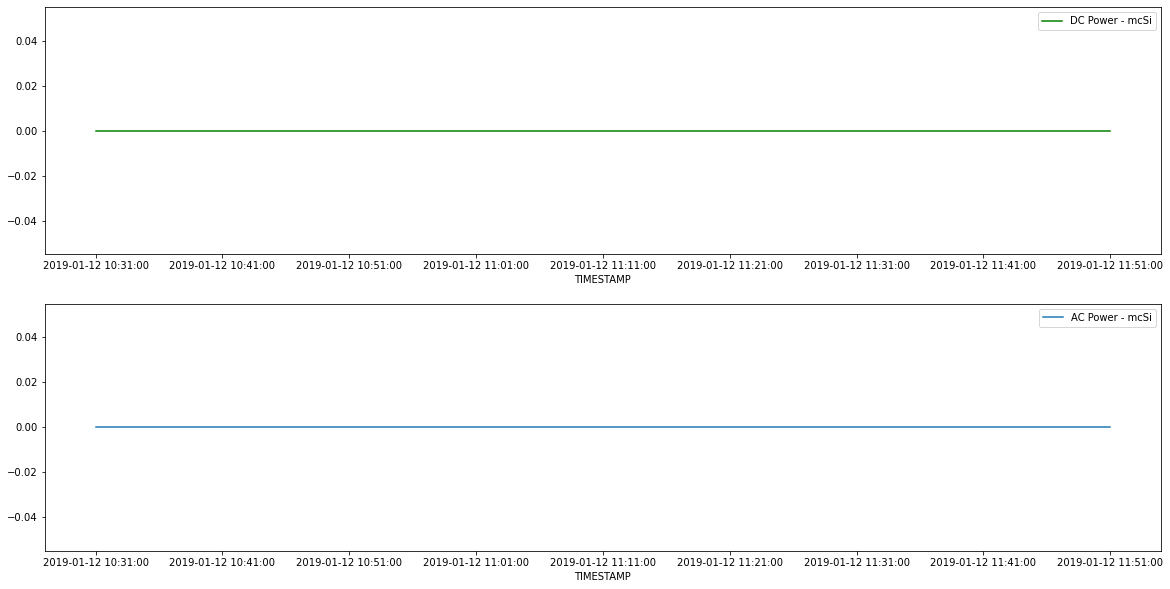

In [157]:

fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfPSI['P_in1'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[0],color = 'green',label='DC Power - mcSi')
#l1=axes[0].axhline(2750,color='red',ls='--')
#l1.set_label('Max Output')
axes[0].legend(loc='best')

f2= dfPSI['P_grid'].loc['2019-01-12 10:31:00':'2019-01-12 11:51:00'].plot(ax=axes[1],label='AC Power - mcSi')
#l2=axes[1].axhline(2750,color='red',ls='--')
#l2.set_label('Max Output')
axes[1].legend(loc='best')

array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>], dtype=object)

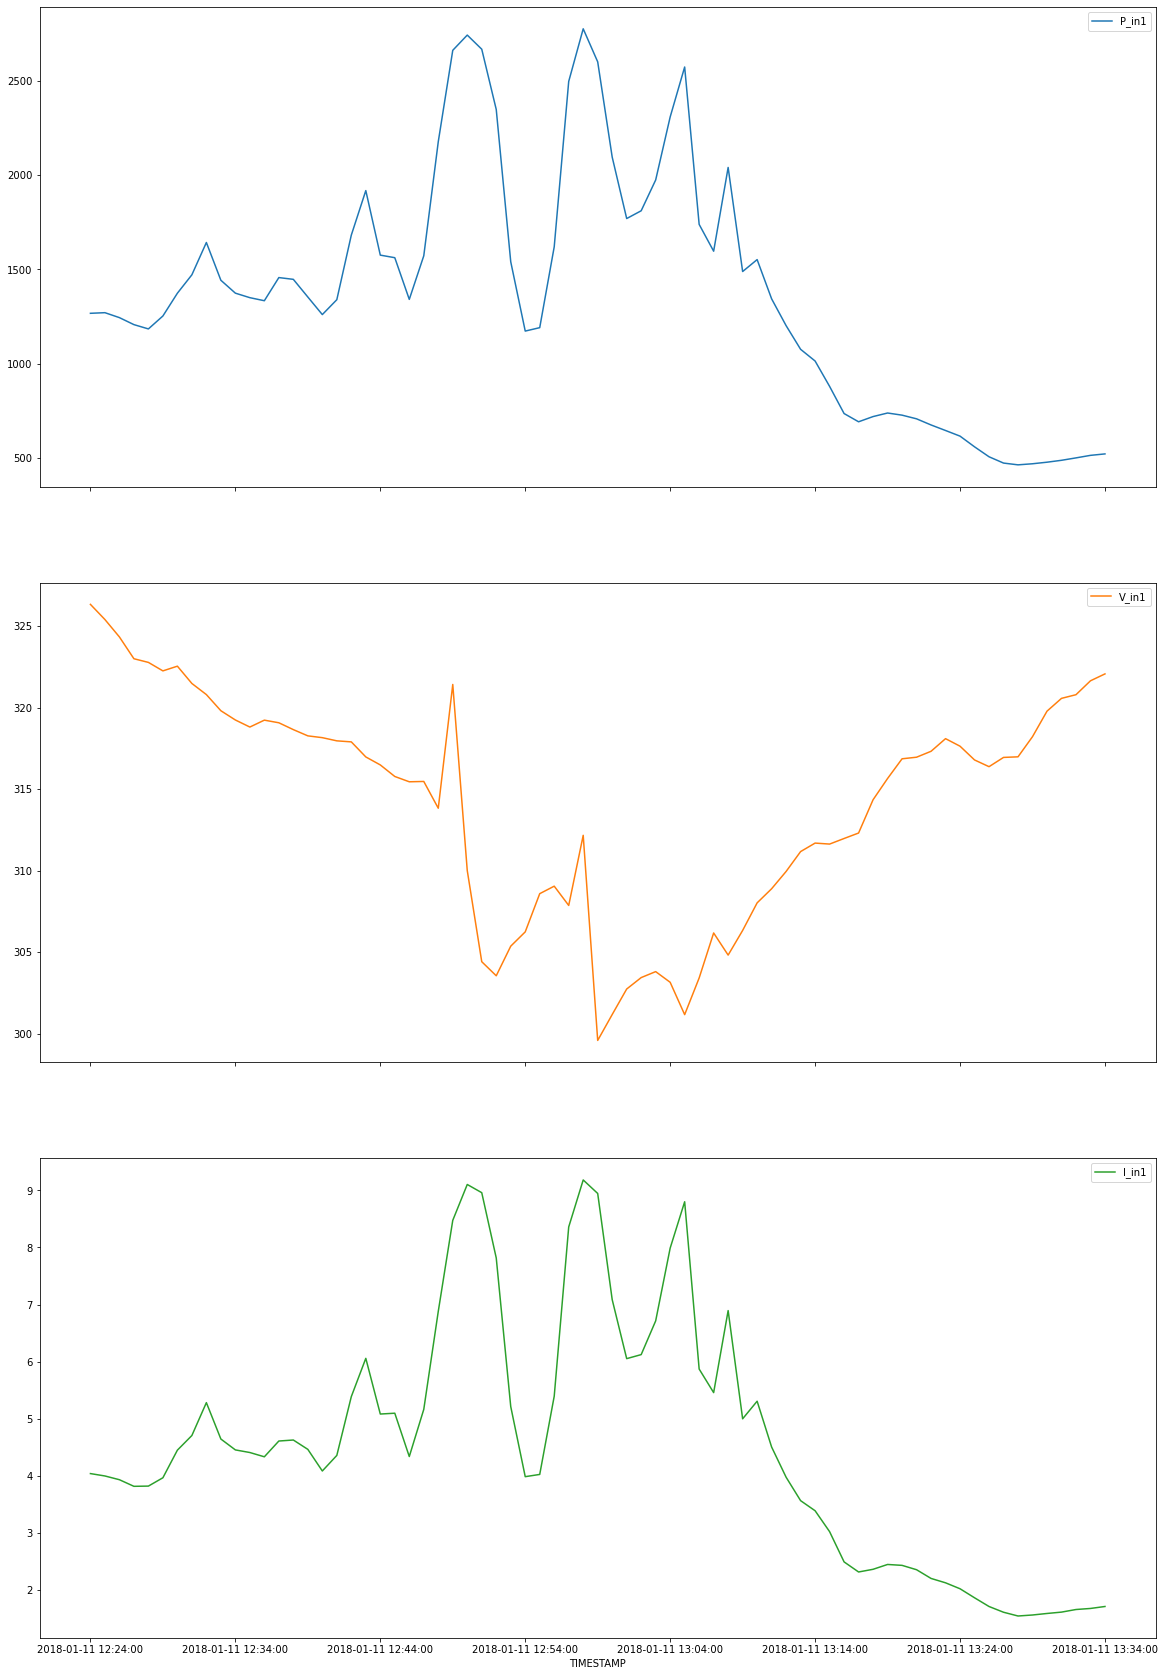

In [80]:
dfCDT[input1].loc['2018-01-11 12:24:00':'2018-01-11 13:34:00'].plot(subplots=True, figsize=(20, 30))


array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>],
      dtype=object)

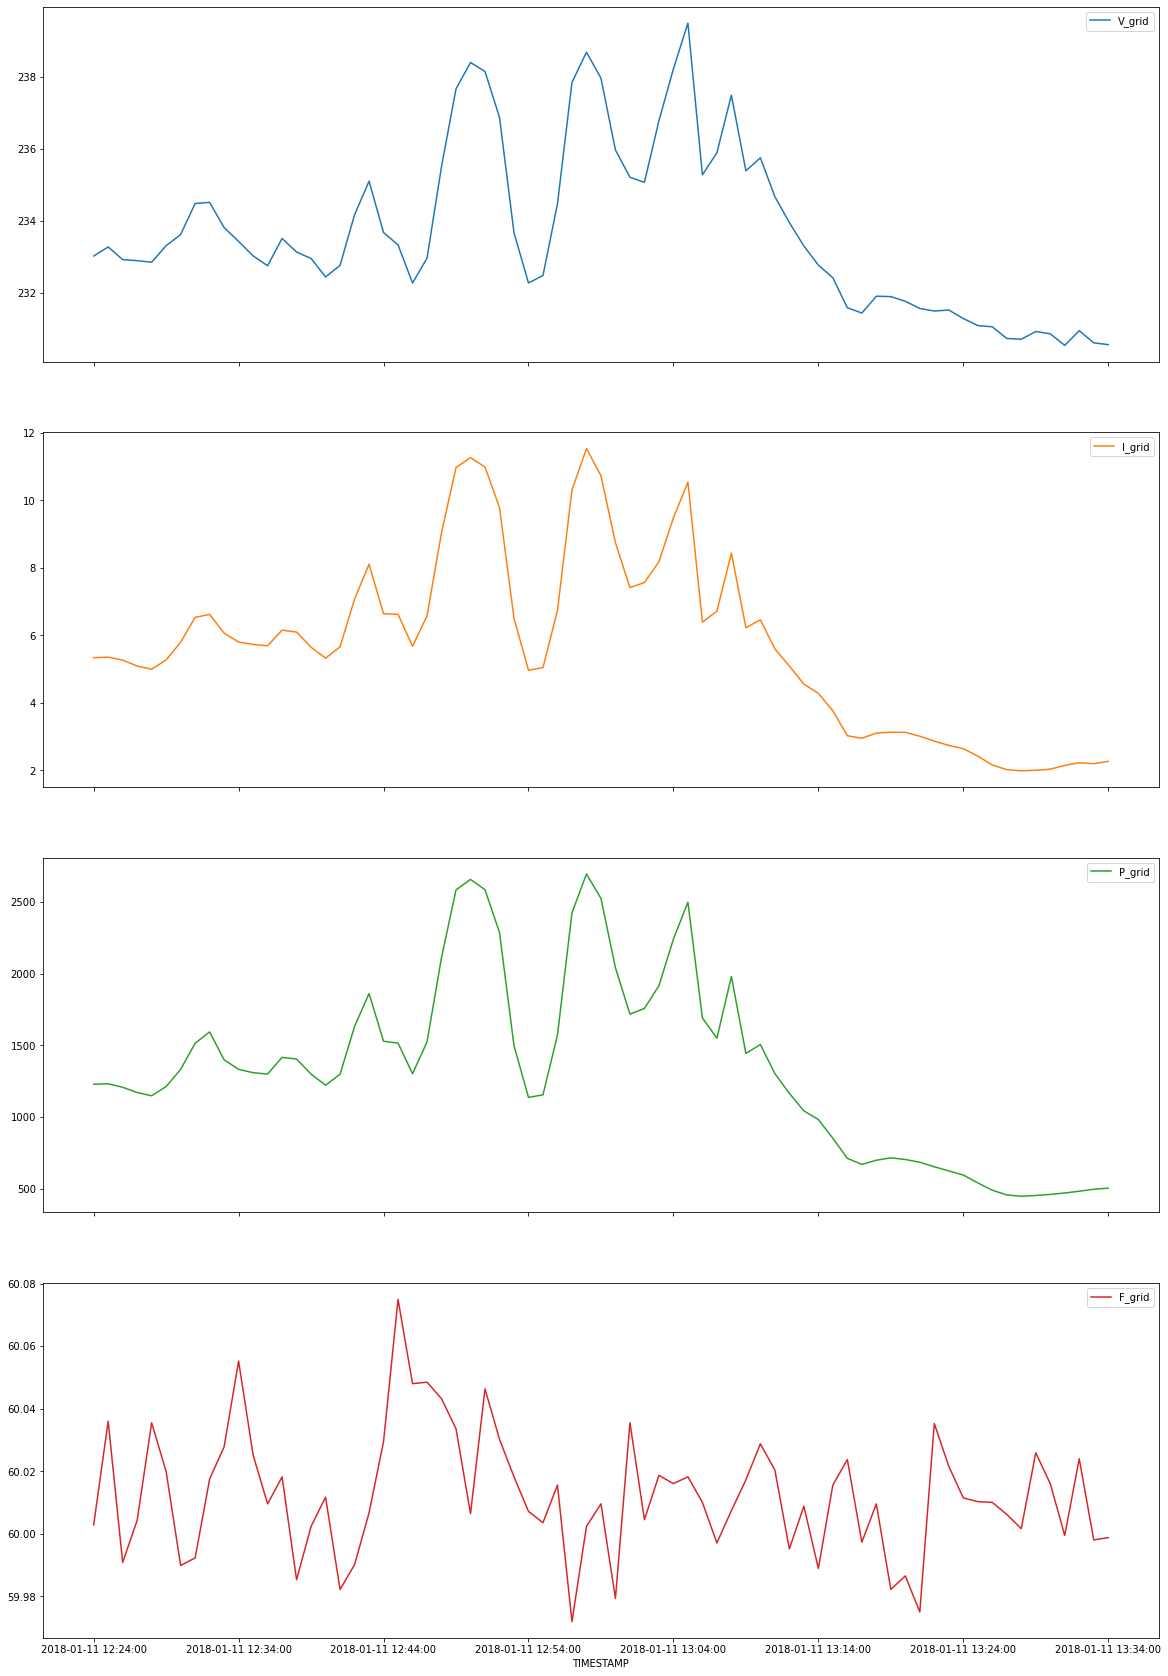

In [83]:
dfCDT[grid].loc['2018-01-11 12:24:00':'2018-01-11 13:34:00'].plot(subplots=True, figsize=(20, 30))


array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>], dtype=object)

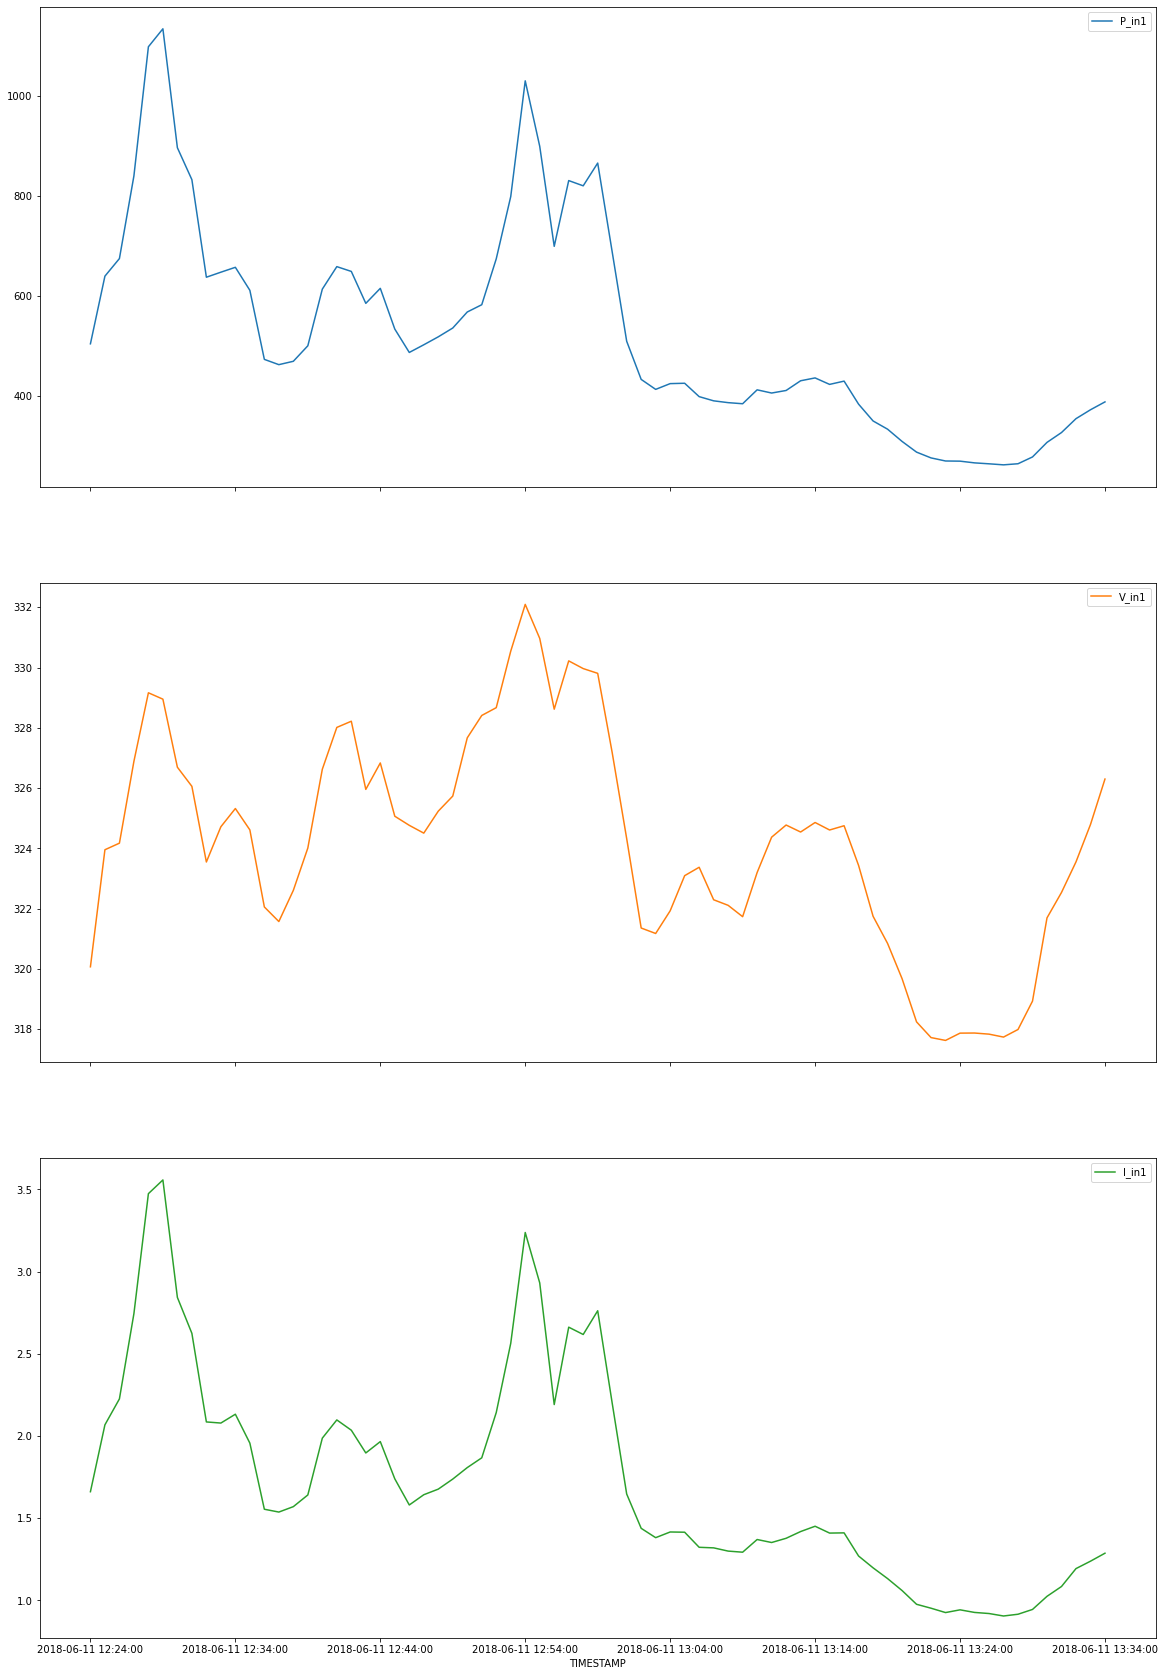

In [84]:
dfCDT[input1].loc['2018-06-11 12:24:00':'2018-06-11 13:34:00'].plot(subplots=True, figsize=(20, 30))


In [87]:
dfCDT[input1].loc['2018-01-11 12:40:00':'2018-01-11 13:00:00']


,P_in1,V_in1,I_in1
TIMESTAMP,,,
2018-01-11 12:40:00,1259.957,318.1548,4.080077
2018-01-11 12:41:00,1338.993,317.9599,4.353177
2018-01-11 12:42:00,1681.914,317.8961,5.384624
2018-01-11 12:43:00,1918.246,316.9724,6.055542
2018-01-11 12:44:00,1575.649,316.4820,5.078994
2018-01-11 12:45:00,1562.002,315.7733,5.093368
2018-01-11 12:46:00,1340.675,315.4474,4.333508
2018-01-11 12:47:00,1572.091,315.4676,5.160913
2018-01-11 12:48:00,2177.863,313.8250,6.879597


In [88]:
dfCDT[grid].loc['2018-01-11 12:40:00':'2018-01-11 13:00:00']


,V_grid,I_grid,P_grid,F_grid
TIMESTAMP,,,,
2018-01-11 12:40:00,232.4462,5.324231,1222.159,60.01176
2018-01-11 12:41:00,232.7686,5.660010,1298.824,59.98224
2018-01-11 12:42:00,234.1715,7.076950,1631.457,59.99016
2018-01-11 12:43:00,235.1011,8.109544,1860.699,60.00673
2018-01-11 12:44:00,233.6774,6.639884,1528.379,60.02953
2018-01-11 12:45:00,233.3350,6.624582,1515.581,60.07498
2018-01-11 12:46:00,232.2791,5.673449,1301.710,60.04804
2018-01-11 12:47:00,232.9656,6.577886,1524.176,60.04852
2018-01-11 12:48:00,235.5080,9.043835,2112.527,60.04323


In [97]:
acdc = ['P_in1', 'P_grid']

array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>],
      dtype=object)

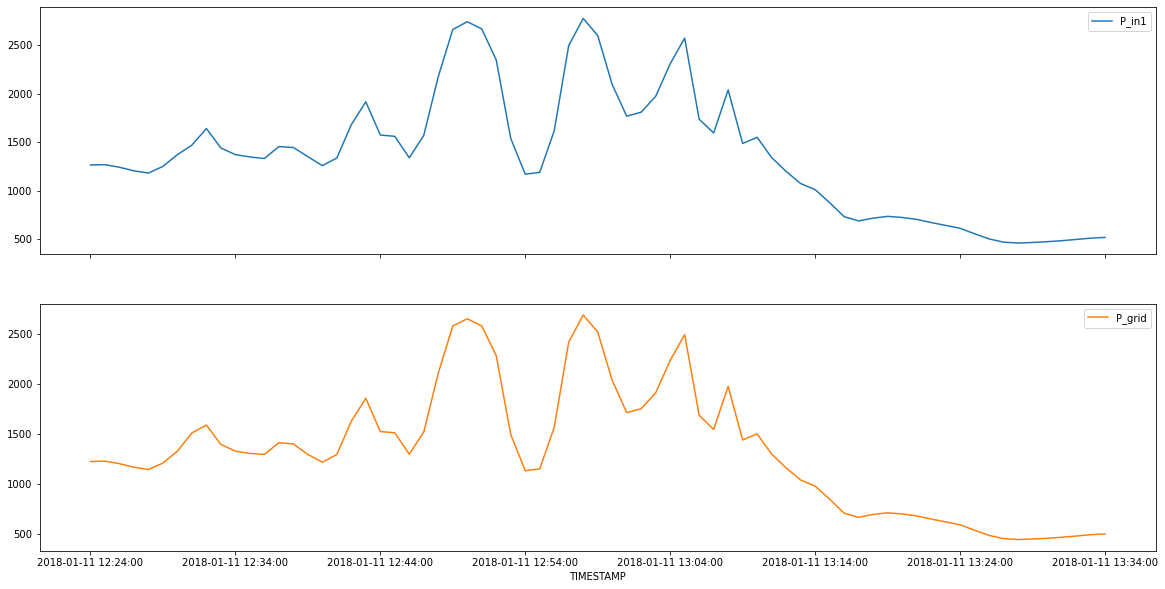

In [102]:
dfCDT[acdc].loc['2018-01-11 12:24:00':'2018-01-11 13:34:00'].plot(subplots=True, figsize=(20,10))


NameError: name 'axes' is not defined

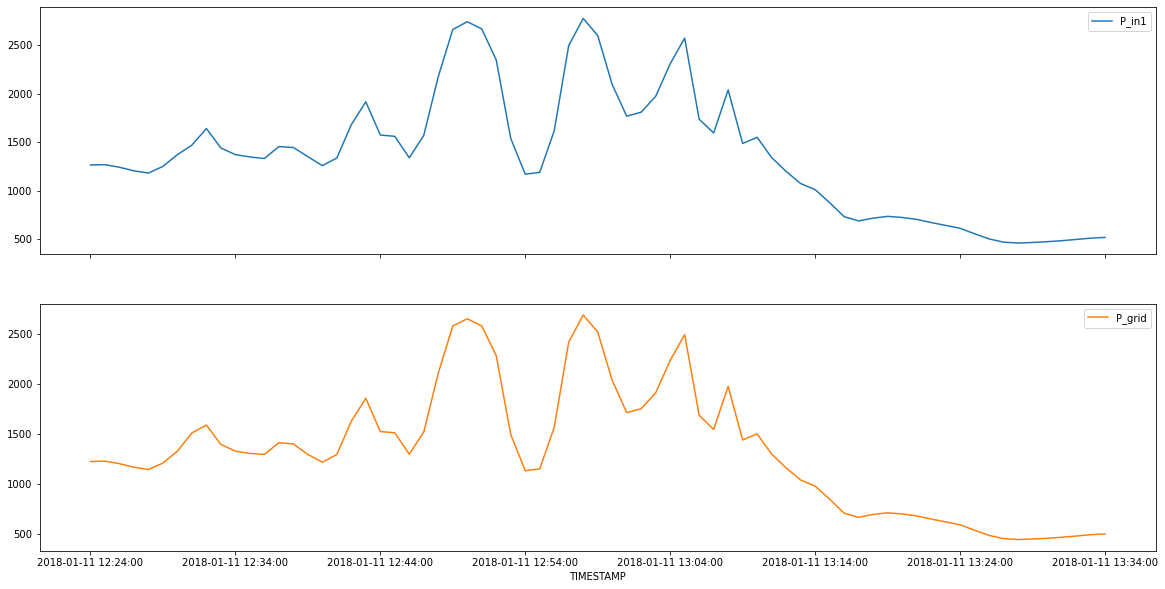

In [106]:
pacdc = dfCDT[acdc].loc['2018-01-11 12:24:00':'2018-01-11 13:34:00'].plot(subplots=True, figsize=(20,10))
l1=axes[0].axhline(2750,color='black',ls='--')


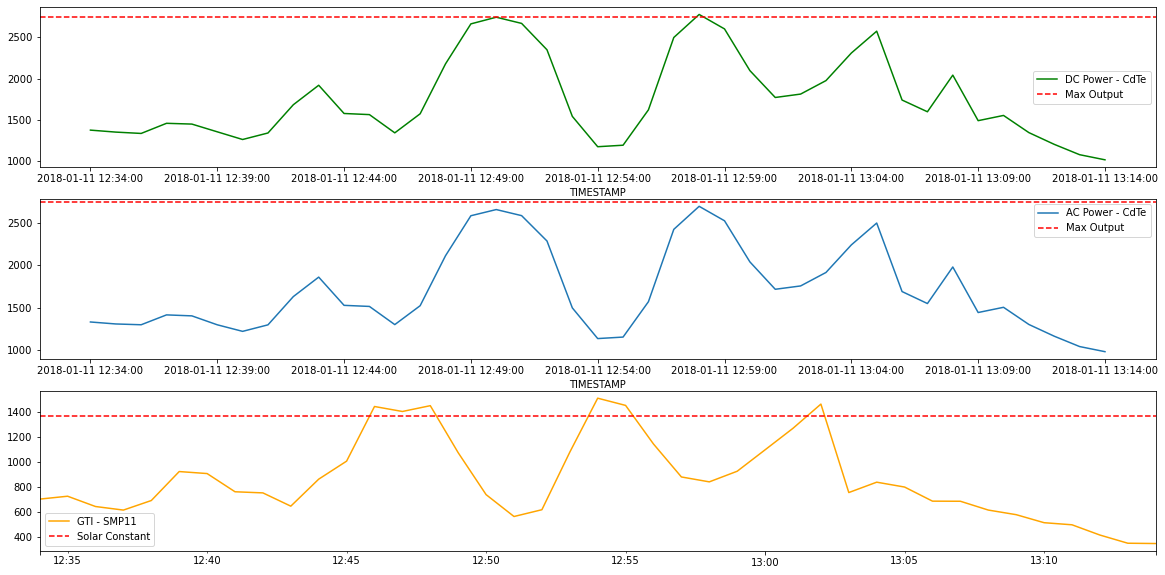

In [149]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(20,10))

f1= dfCDT['P_in1'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTe')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfCDT['P_grid'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[1],label='AC Power - CdTe')

l2=axes[1].axhline(2750,color='red',ls='--')
l2.set_label('Max Output')
axes[1].legend(loc='best')

f3 = dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[2],color = 'orange',label='GTI - SMP11')
l3=axes[2].axhline(1366.1,color='red',ls='--')
l3.set_label('Solar Constant')
axes[2].legend(loc='best')



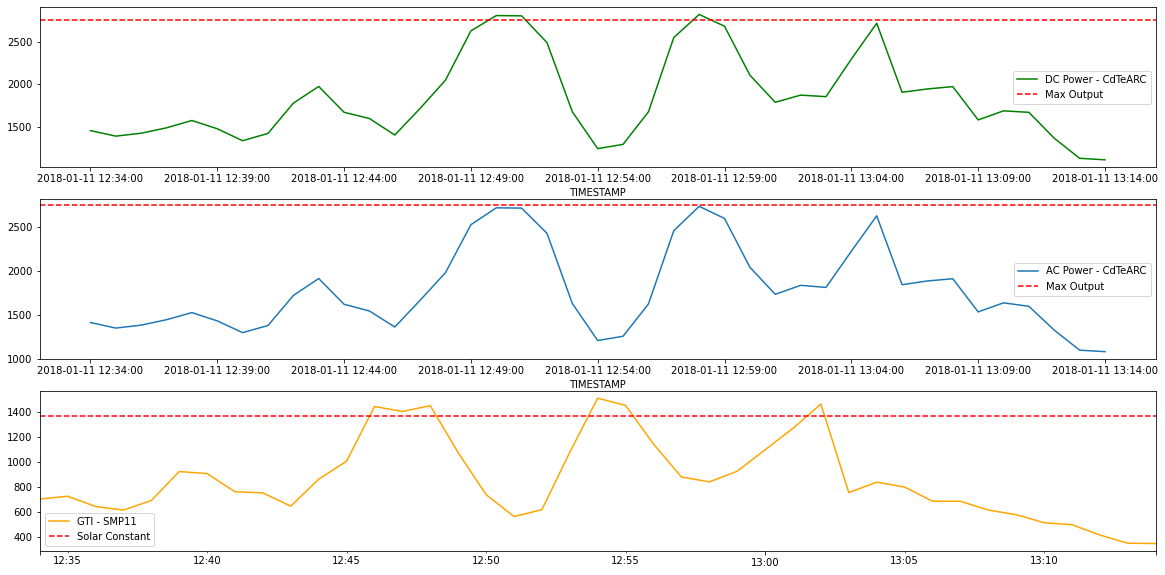

In [150]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(20,10))

f1= dfCDTA['P_in1'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTeARC')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfCDTA['P_grid'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[1],label='AC Power - CdTeARC')

l2=axes[1].axhline(2750,color='red',ls='--')

l2.set_label('Max Output')

axes[1].legend(loc='best')

f3 = dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[2],color = 'orange',label='GTI - SMP11')
l3=axes[2].axhline(1366.1,color='red',ls='--')
l3.set_label('Solar Constant')
axes[2].legend(loc='best')

In [152]:
dfCDTA['P_in1'].loc['2018-01-11 12:39:00':'2018-01-11 13:10:00']

TIMESTAMP
2018-01-11 12:39:00    1478.440
2018-01-11 12:40:00    1338.132
2018-01-11 12:41:00    1423.869
2018-01-11 12:42:00    1778.616
2018-01-11 12:43:00    1974.474
2018-01-11 12:44:00    1671.429
2018-01-11 12:45:00    1598.406
2018-01-11 12:46:00    1404.765
2018-01-11 12:47:00    1717.460
2018-01-11 12:48:00    2049.062
2018-01-11 12:49:00    2625.812
2018-01-11 12:50:00    2805.370
2018-01-11 12:51:00    2802.110
2018-01-11 12:52:00    2488.633
2018-01-11 12:53:00    1677.623
2018-01-11 12:54:00    1245.289
2018-01-11 12:55:00    1295.557
2018-01-11 12:56:00    1676.515
2018-01-11 12:57:00    2547.899
2018-01-11 12:58:00    2818.409
2018-01-11 12:59:00    2680.709
2018-01-11 13:00:00    2107.089
2018-01-11 13:01:00    1788.527
2018-01-11 13:02:00    1872.764
2018-01-11 13:03:00    1854.769
2018-01-11 13:04:00    2294.862
2018-01-11 13:05:00    2715.265
2018-01-11 13:06:00    1906.211
2018-01-11 13:07:00    1945.004
2018-01-11 13:08:00    1972.714
2018-01-11 13:09:00    1582.10

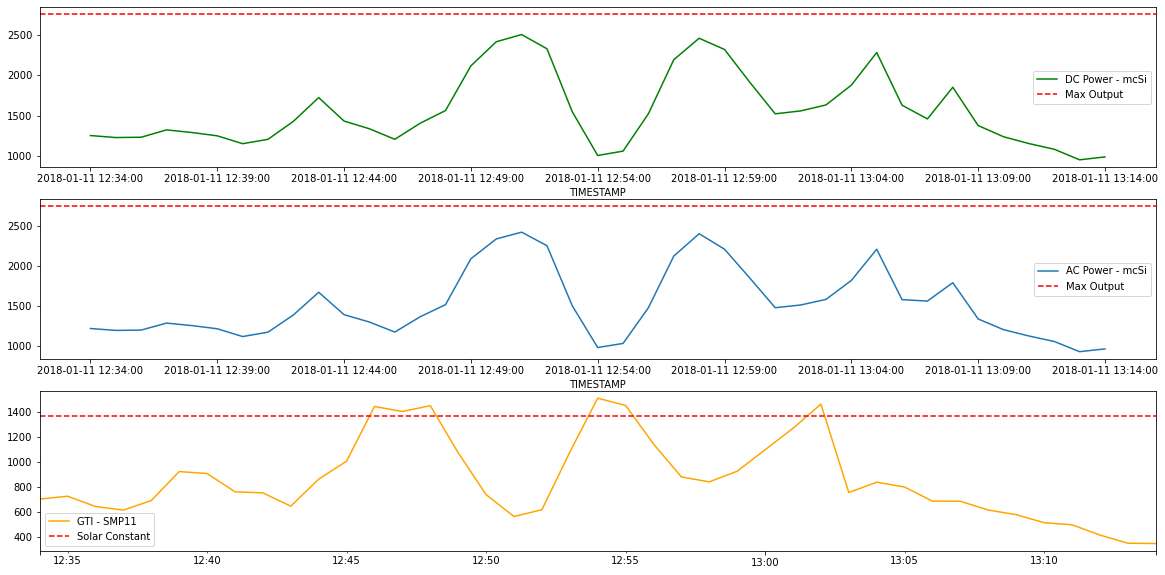

In [151]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(20,10))

f1= dfPSI['P_in1'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[0],color = 'green',label='DC Power - mcSi')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfPSI['P_grid'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[1],label='AC Power - mcSi')

l2=axes[1].axhline(2750,color='red',ls='--')

l2.set_label('Max Output')

axes[1].legend(loc='best')

f3 = dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[2],color = 'orange',label='GTI - SMP11')
l3=axes[2].axhline(1366.1,color='red',ls='--')
l3.set_label('Solar Constant')
axes[2].legend(loc='best')

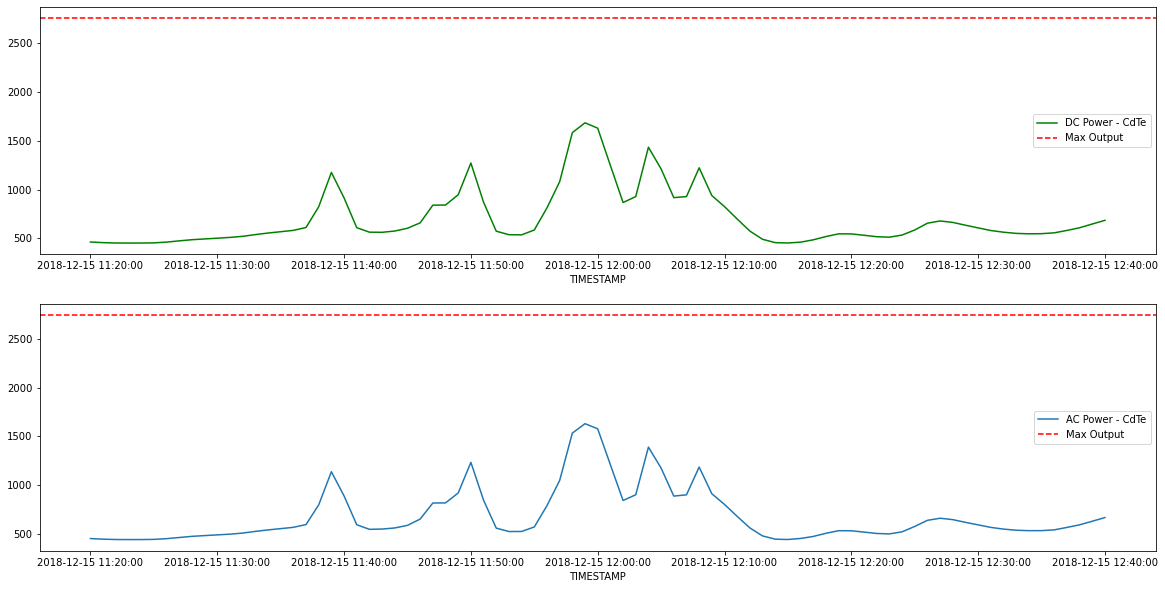

In [125]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfCDT['P_in1'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTe')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfCDT['P_grid'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[1],label='AC Power - CdTe')

l2=axes[1].axhline(2750,color='red',ls='--')

l2.set_label('Max Output')

axes[1].legend(loc='best')

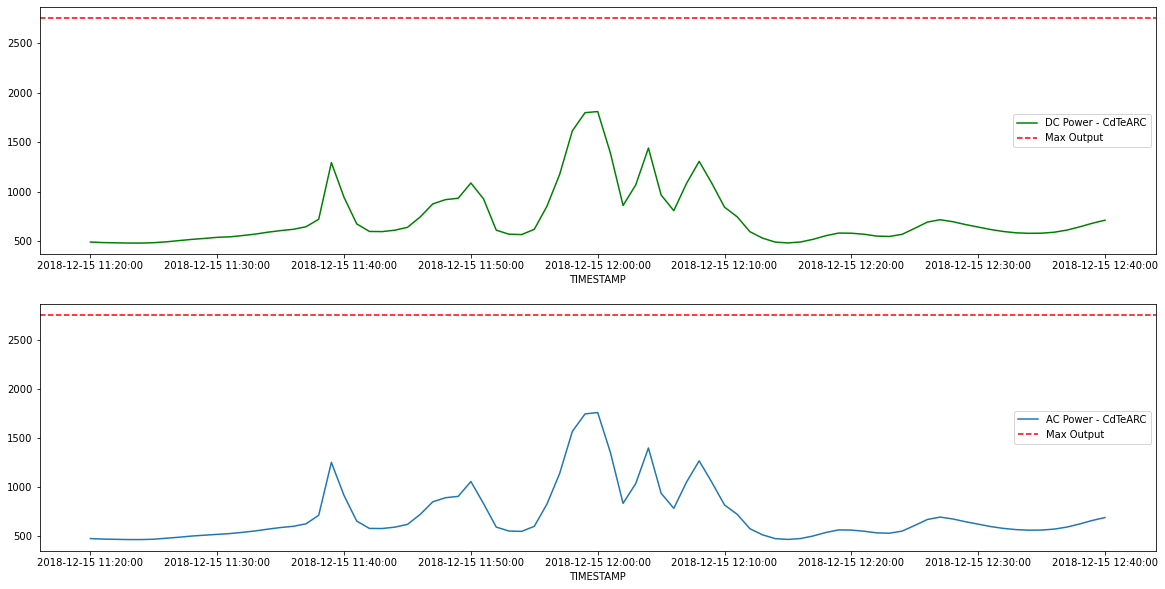

In [126]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfCDTA['P_in1'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTeARC')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfCDTA['P_grid'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[1],label='AC Power - CdTeARC')

l2=axes[1].axhline(2750,color='red',ls='--')

l2.set_label('Max Output')

axes[1].legend(loc='best')

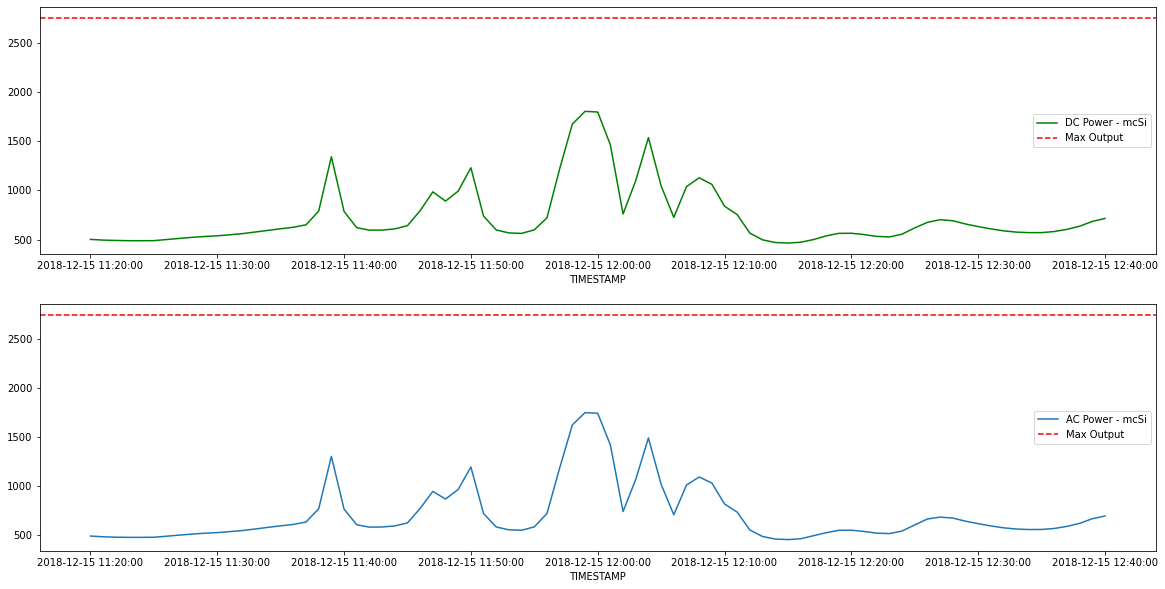

In [127]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(20,10))

f1= dfPSI['P_in1'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[0],color = 'green',label='DC Power - mcSi')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')

axes[0].legend(loc='best')

f2= dfPSI['P_grid'].loc['2018-12-15 11:20:00':'2018-12-15 12:40:00'].plot(ax=axes[1],label='AC Power - mcSi')

l2=axes[1].axhline(2750,color='red',ls='--')

l2.set_label('Max Output')

axes[1].legend(loc='best')

In [130]:
dfCDTA['P_in1'].loc['2018-01-11 12:49:00':'2018-01-11 13:00:00']

TIMESTAMP
2018-01-11 12:49:00    2625.812
2018-01-11 12:50:00    2805.370
2018-01-11 12:51:00    2802.110
2018-01-11 12:52:00    2488.633
2018-01-11 12:53:00    1677.623
2018-01-11 12:54:00    1245.289
2018-01-11 12:55:00    1295.557
2018-01-11 12:56:00    1676.515
2018-01-11 12:57:00    2547.899
2018-01-11 12:58:00    2818.409
2018-01-11 12:59:00    2680.709
2018-01-11 13:00:00    2107.089
Name: P_in1, dtype: float64

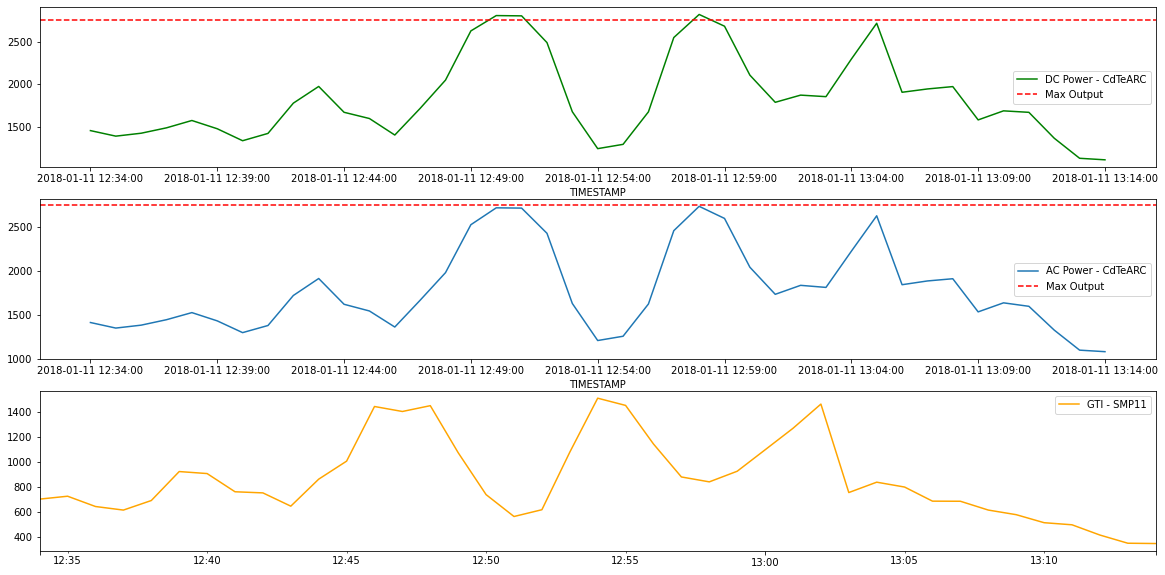

In [144]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(20,10))

f1= dfCDTA['P_in1'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[0],color = 'green',label='DC Power - CdTeARC')
l1=axes[0].axhline(2750,color='red',ls='--')
l1.set_label('Max Output')
axes[0].legend(loc='best')

f2= dfCDTA['P_grid'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[1],label='AC Power - CdTeARC')
l2=axes[1].axhline(2750,color='red',ls='--')
l2.set_label('Max Output')
axes[1].legend(loc='best')

f3 = dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00'].plot(ax=axes[2],color = 'orange',label='GTI - SMP11')
axes[2].legend(loc='best')


In [136]:
dfgti['TGIP_SMP11_VENT'].loc['2018-01-11 12:34:00':'2018-01-11 13:14:00']

2018-01-11 12:34:00+00:00    147.678333
2018-01-11 12:35:00+00:00    145.621667
2018-01-11 12:36:00+00:00    141.658333
2018-01-11 12:37:00+00:00    138.033333
2018-01-11 12:38:00+00:00    139.086667
2018-01-11 12:39:00+00:00    139.610000
2018-01-11 12:40:00+00:00    137.163333
2018-01-11 12:41:00+00:00    130.138333
2018-01-11 12:42:00+00:00    118.600000
2018-01-11 12:43:00+00:00    106.656667
2018-01-11 12:44:00+00:00     96.928333
2018-01-11 12:45:00+00:00     89.675000
2018-01-11 12:46:00+00:00     80.985000
2018-01-11 12:47:00+00:00     71.251667
2018-01-11 12:48:00+00:00     64.946667
2018-01-11 12:49:00+00:00     61.811667
2018-01-11 12:50:00+00:00     58.983333
2018-01-11 12:51:00+00:00     57.711667
2018-01-11 12:52:00+00:00     58.505000
2018-01-11 12:53:00+00:00     58.641667
2018-01-11 12:54:00+00:00     59.258333
2018-01-11 12:55:00+00:00     60.845000
2018-01-11 12:56:00+00:00     62.721667
2018-01-11 12:57:00+00:00     63.716667
2018-01-11 12:58:00+00:00     65.745000


In [141]:
dfgti.index = dfgti.index.tz_convert('Etc/GMT+3')

In [142]:
dfgti

,PPmax,PPmin,F_TGHIP_SI02pt100,F_TGHIP_SI02pt100_dirty,F_TGIP_SMP11_VENT,TGHIP_SI02pt100,TGHIP_SI02pt100_dirty,TGIP_SMP11_VENT
2017-12-31 21:00:00-03:00,NaN,-5.609741,0,0,0,0.000983,0.000000,-0.823333
2017-12-31 21:01:00-03:00,NaN,-5.597594,0,0,0,0.000000,0.000000,-0.800000
2017-12-31 21:02:00-03:00,NaN,-5.585493,0,0,0,0.000000,0.000000,-0.800000
2017-12-31 21:03:00-03:00,NaN,-5.573438,0,0,0,0.000000,0.000000,-0.890000
2017-12-31 21:04:00-03:00,NaN,-5.561430,0,0,0,0.000983,0.000000,-1.105000
...,...,...,...,...,...,...,...,...
2018-12-31 14:16:00-03:00,2509.327518,-11.205603,0,0,0,823.016667,832.416667,854.533333
2018-12-31 14:17:00-03:00,2503.557918,-11.197597,0,0,0,803.428333,812.798333,835.288333
2018-12-31 14:18:00-03:00,2497.745823,-11.189531,0,0,0,839.900000,849.333333,870.616667
2018-12-31 14:19:00-03:00,2491.891373,-11.181404,0,0,0,780.556667,789.781667,811.420000


In [159]:
interest = dfCDTA[dfCDTA['P_in1']>2750]

In [160]:
interest

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2017-11-06 11:26:00,3650.608,238.5798,11.27777,2661.065,60.02185,2758.035,313.6940,9.067749,0,0,0,50.26563,46.63038,5.0
2017-11-06 12:54:00,3652.936,234.2799,11.66291,2705.841,59.99424,2790.114,335.3056,8.465135,0,0,0,46.96143,43.20889,5.0
2017-11-17 11:15:00,3763.628,235.1592,11.24893,2673.271,59.99424,2755.949,328.8296,8.593850,0,0,0,45.65779,40.38450,5.0
2017-11-17 11:23:00,3763.920,236.0198,11.42936,2674.662,59.99664,2757.384,302.9588,9.177336,0,0,0,46.64844,41.06981,5.0
2017-11-17 11:24:00,3763.964,236.1155,11.55693,2703.880,60.01297,2789.983,301.7361,9.414231,0,0,0,46.85710,41.63173,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-15 15:59:00,13677.390,227.1727,12.12756,2728.988,59.96379,2813.716,303.7078,9.579042,0,0,0,47.67879,46.93806,5.0
2021-01-15 16:00:00,13677.430,227.4892,11.92072,2680.607,60.01537,2771.336,294.9913,9.561211,0,0,0,47.95752,47.76361,5.0
2021-01-15 16:14:00,13677.810,227.2085,12.14811,2734.110,59.98368,2818.671,312.6662,9.299891,0,0,0,50.26563,47.62259,5.0


In [163]:
interest.head(50)

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2017-11-06 11:26:00,3650.608,238.5798,11.27777,2661.065,60.02185,2758.035,313.6940,9.067749,0,0,0,50.26563,46.63038,5.0
2017-11-06 12:54:00,3652.936,234.2799,11.66291,2705.841,59.99424,2790.114,335.3056,8.465135,0,0,0,46.96143,43.20889,5.0
2017-11-17 11:15:00,3763.628,235.1592,11.24893,2673.271,59.99424,2755.949,328.8296,8.593850,0,0,0,45.65779,40.38450,5.0
2017-11-17 11:23:00,3763.920,236.0198,11.42936,2674.662,59.99664,2757.384,302.9588,9.177336,0,0,0,46.64844,41.06981,5.0
2017-11-17 11:24:00,3763.964,236.1155,11.55693,2703.880,60.01297,2789.983,301.7361,9.414231,0,0,0,46.85710,41.63173,5.0
2017-11-26 11:19:00,3867.563,235.6300,11.16754,2607.435,59.96881,2798.915,323.9254,8.402993,0,0,0,44.64355,39.05225,5.0
2017-12-01 12:24:00,3932.649,235.7228,11.71857,2734.743,59.95923,2819.257,337.5965,8.448491,0,0,0,44.06787,41.58334,5.0
2017-12-01 12:25:00,3932.690,236.1101,11.70209,2736.767,59.97721,2821.409,335.0840,8.559915,0,0,0,44.41951,42.62937,5.0
2017-12-01 12:30:00,3932.817,235.8630,11.51016,2673.207,59.99160,2755.884,313.2473,9.054564,0,0,0,45.29387,41.87542,5.0


In [164]:
interest.tail(55)

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2018-11-11 11:16:00,6830.072,225.8912,11.99552,2717.035,59.98729,2801.067,305.7433,9.407855,0,0,0,46.46289,39.44800,5.0
2018-11-24 10:24:00,6983.756,222.9778,11.69805,2584.478,59.99280,2793.047,323.8213,8.755202,0,0,0,38.45923,34.39403,5.0
2018-11-24 10:25:00,6983.803,223.2079,12.01917,2662.772,59.99616,2802.240,317.5905,8.645400,0,0,0,38.78206,35.51651,5.0
2018-12-07 14:35:00,7120.477,226.2897,12.13888,2697.114,60.00673,2757.340,327.0056,8.301296,0,0,0,36.18213,30.29349,5.0
2018-12-07 15:20:00,7121.328,226.7040,12.17373,2728.798,60.00960,2812.020,325.4336,8.752285,0,0,0,37.85449,32.91670,5.0
2018-12-07 15:21:00,7121.367,226.3864,12.22930,2732.213,59.98752,2802.839,326.4044,8.361169,0,0,0,37.94629,33.61998,5.0
2018-12-07 15:24:00,7121.459,226.4445,12.19544,2732.150,59.99040,2816.649,330.5796,8.954597,0,0,0,38.56999,33.90335,5.0
2019-01-06 16:27:00,7467.498,224.3488,11.98380,2674.726,59.97290,2757.449,299.6367,9.366355,0,0,0,48.37842,45.13091,5.0
2019-01-19 14:53:00,7614.627,221.1637,12.47557,2730.316,60.00528,2810.455,324.8794,8.692953,0,0,0,52.61572,48.18640,5.0


In [168]:
interest.P_in1.max()

2825.712

In [194]:
interest[interest.P_in1==2825.712]

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2020-01-10 14:52:00,10582.69,222.7366,12.39177,2733.352,60.0168,2825.712,333.0619,8.402452,0,0,0,46.80371,40.99756,5.0


In [171]:
cdteaeff =  interest.P_grid / interest.P_in1 

<AxesSubplot:>

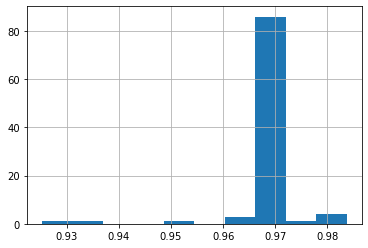

In [173]:
cdteaeff.hist()

In [209]:
cdteaeff[cdteaeff<0.95]

TIMESTAMP
2017-11-26 11:19:00    0.931588
2018-11-24 10:24:00    0.925326
dtype: float64

In [174]:
interestCdTe = dfCDT[dfCDT['P_in1']>2750]

In [175]:
interestCdTe.shape

(26, 14)

In [176]:
interestCdTe

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2017-12-01 12:30:00,3431.114,241.1383,11.25111,2680.802,60.01080,2763.066,305.5183,9.118219,0.0,0,0,44.86499,41.75370,5.0
2017-12-01 12:39:00,3431.327,240.4374,11.31708,2688.706,59.98465,2772.897,309.9118,9.263794,0.0,0,0,45.62891,41.29026,5.0
2017-12-01 12:45:00,3431.530,240.3046,11.49484,2726.098,60.00600,2810.410,312.5856,9.199058,0.0,0,0,46.38110,43.25706,5.0
2017-12-23 12:17:00,3665.304,241.3723,11.47580,2733.438,59.99712,2817.395,323.7105,8.925526,0.0,0,0,45.74446,41.77883,5.0
2017-12-23 12:18:00,3665.348,241.2220,11.10244,2681.617,60.00888,2764.553,305.6057,9.537110,0.0,0,0,46.21647,42.74930,5.0
2018-01-11 12:58:00,3819.015,238.6771,11.53664,2693.976,60.00240,2777.295,312.1624,9.184684,0.0,0,0,44.91992,41.48515,5.0
2018-01-31 12:55:00,4020.216,239.9425,11.46572,2732.999,59.93766,2817.524,337.0657,8.596984,0.0,0,0,45.46729,41.92419,5.0
2018-01-31 12:56:00,4020.257,240.1796,11.38444,2732.873,59.95419,2817.395,335.9640,8.648211,0.0,0,0,45.54810,42.60423,5.0
2018-02-03 13:14:00,4050.238,239.2162,11.30841,2669.258,59.98656,2751.812,313.6201,8.981939,0.0,0,0,44.91992,42.94368,5.0


In [177]:
interestCdTe.max()

E_tot         12914.420000
V_grid          241.372300
I_grid           12.104740
P_grid         2737.014000
F_grid           60.078820
P_in1          2819.724000
V_in1           355.351900
I_in1             9.602062
P_in2             0.000000
V_in2             0.000000
I_in2             0.000000
T_inverter       51.621090
T_booster        45.630420
R_iso             5.000000
dtype: float64

In [192]:
interestCdTe[interestCdTe['P_in1']==2819.724]

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2020-11-19 15:42:00,12342.1,232.4193,11.92235,2737.014,59.99952,2819.724,331.0465,9.013929,0.0,0,0,36.76318,32.36792,5.0


<AxesSubplot:>

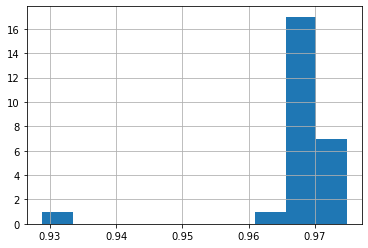

In [179]:
cdteeff =  interestCdTe.P_grid / interestCdTe.P_in1 
cdteeff.hist()

In [205]:
cdteeff

TIMESTAMP
2017-12-01 12:30:00    0.970227
2017-12-01 12:39:00    0.969638
2017-12-01 12:45:00    0.970000
2017-12-23 12:17:00    0.970200
2017-12-23 12:18:00    0.970000
2018-01-11 12:58:00    0.970000
2018-01-31 12:55:00    0.970000
2018-01-31 12:56:00    0.970000
2018-02-03 13:14:00    0.970000
2018-02-08 12:09:00    0.970000
2018-10-04 13:05:00    0.964987
2019-01-25 14:58:00    0.970357
2019-02-04 16:02:00    0.973818
2019-02-05 14:25:00    0.928843
2019-02-05 15:45:00    0.974748
2019-02-05 15:46:00    0.970000
2019-02-05 15:56:00    0.968770
2019-03-04 16:47:00    0.969865
2020-01-10 14:24:00    0.970000
2020-02-16 15:52:00    0.970000
2020-10-30 15:02:00    0.970000
2020-11-12 15:02:00    0.970000
2020-11-19 15:42:00    0.970667
2021-01-10 14:49:00    0.968583
2021-01-16 14:12:00    0.970000
2021-01-17 15:55:00    0.971262
dtype: float64

In [237]:
cdteeff[cdteeff<0.95]

TIMESTAMP
2019-02-05 14:25:00    0.928843
dtype: float64

In [238]:
cdteaeff[cdteaeff<0.95]

TIMESTAMP
2017-11-26 11:19:00    0.931588
2018-11-24 10:24:00    0.925326
dtype: float64

In [242]:
PSIeff[PSIeff<0.95]

TIMESTAMP
2019-03-14 15:07:00    0.925435
2019-09-23 15:58:00    0.942605
dtype: float64

In [180]:
interestPSI = dfPSI[dfPSI['P_in1']>2750]

In [183]:
interestPSI.head(50)

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2018-11-07 12:11:00,2944.005,228.6085,12.09708,2738.824,60.02401,2823.530,290.4567,9.953839,0,0,0,42.05151,38.47987,0.0
2018-11-07 12:24:00,2944.360,229.1633,12.05637,2736.657,59.98944,2821.296,275.4925,10.582070,0,0,0,43.62899,40.11395,0.0
2018-11-09 11:31:00,2954.507,229.9593,11.76690,2671.139,60.00816,2772.215,257.8680,11.084390,0,0,0,48.45508,42.79855,0.0
2018-11-09 11:38:00,2954.695,230.1686,11.95426,2723.974,59.99184,2808.221,259.7692,11.124380,0,0,0,48.30176,43.11218,0.0
2018-11-24 10:24:00,3130.484,227.9012,11.90937,2689.176,60.01632,2765.776,263.3901,10.406340,0,0,0,40.21663,37.98351,0.0
2019-01-25 14:58:00,3811.094,226.7338,12.02816,2706.766,59.98800,2791.006,259.6012,10.990150,0,0,0,48.01155,48.13816,0.0
2019-01-25 16:40:00,3812.975,229.0624,11.76296,2668.399,60.01200,2751.321,260.7768,10.759310,0,0,0,46.02913,43.85972,0.0
2019-02-02 15:21:00,3909.212,226.9771,12.11117,2728.691,59.97217,2812.688,251.3381,11.350900,0,0,0,53.59717,49.60928,0.0
2019-02-05 14:26:00,3934.489,230.1006,11.86524,2702.241,60.04107,2795.671,279.3654,10.188900,0,0,0,42.62484,39.34964,0.0


In [184]:
interestPSI.tail(55)

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2019-02-02 15:21:00,3909.212,226.9771,12.11117,2728.691,59.97217,2812.688,251.3381,11.350900,0,0,0,53.59717,49.60928,0.0
2019-02-05 14:26:00,3934.489,230.1006,11.86524,2702.241,60.04107,2795.671,279.3654,10.188900,0,0,0,42.62484,39.34964,0.0
2019-02-05 15:55:00,3936.286,228.0546,11.95005,2699.118,60.01008,2771.755,269.2784,10.604760,0,0,0,45.03459,42.43503,0.0
2019-02-12 15:10:00,4022.418,225.9992,11.98020,2686.627,59.94772,2768.930,254.0186,11.141450,0,0,0,49.77979,47.48053,0.0
2019-02-28 16:24:00,4158.464,226.8281,11.86364,2674.008,59.98586,2755.920,256.4471,11.080170,0,0,0,51.35596,47.97508,0.0
2019-03-14 15:07:00,4296.042,227.0268,11.64069,2613.907,60.02425,2824.516,269.8394,11.180360,0,0,0,47.95752,47.19800,0.0
2019-03-14 15:30:00,4296.639,228.5100,11.95579,2710.718,60.03265,2771.295,251.2575,11.272440,0,0,0,49.77979,48.32758,0.0
2019-03-18 16:03:00,4330.558,226.8877,11.98642,2694.402,59.97649,2777.997,281.8141,10.143720,0,0,0,45.83105,41.97296,0.0
2019-03-23 15:52:00,4370.525,227.4067,11.85518,2676.684,59.99376,2759.468,257.6262,11.026030,0,0,0,48.61328,45.91742,0.0


In [185]:
interestPSI.shape

(62, 14)

In [187]:
interestPSI.max()

E_tot         9943.77200
V_grid         233.08050
I_grid          12.31451
P_grid        2743.98600
F_grid          60.04996
P_in1         2825.30400
V_in1          293.85600
I_in1           11.48502
P_in2            0.00000
V_in2            0.00000
I_in2            0.00000
T_inverter      55.89697
T_booster       50.14532
R_iso            0.00000
dtype: float64

In [189]:
interestPSI[interestPSI.P_in1==2825.30400]

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2020-01-10 14:50:00,6573.133,230.1143,12.01835,2739.397,59.98368,2825.304,282.9192,9.982695,0,0,0,50.61816,44.77313,0.0


<AxesSubplot:>

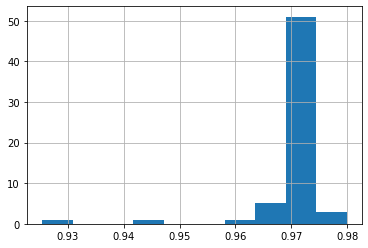

In [195]:
PSIeff =  interestPSI.P_grid / interestPSI.P_in1 
PSIeff.hist()

In [200]:
dfCDTA.loc['2020-01-07 15:20:00':'2020-01-07 15:30:00':]

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2020-01-07 15:20:00,10550.94,223.4517,10.30429,2278.002,60.00672,2348.456,291.5248,8.196033,0,0,0,54.42920,47.81072,5.0
2020-01-07 15:21:00,10550.97,223.8294,10.57173,2343.648,60.01825,2416.132,291.1016,8.443737,0,0,0,54.48259,47.95180,5.0
2020-01-07 15:22:00,10551.01,224.0306,10.72278,2378.875,60.01801,2452.448,291.1352,8.641726,0,0,0,54.58936,48.09254,5.0
2020-01-07 15:23:00,10551.05,223.7372,10.77731,2389.120,59.98896,2461.902,290.4970,8.693602,0,0,0,54.58936,48.32758,5.0
2020-01-07 15:24:00,10551.09,223.9468,10.79312,2394.496,59.99376,2468.552,288.7033,8.650805,0,0,0,54.75977,48.88773,5.0
2020-01-07 15:25:00,10551.13,223.3762,10.85968,2401.326,59.99376,2475.594,288.7033,8.698789,0,0,0,54.91602,48.88773,5.0
2020-01-07 15:26:00,10551.17,223.4182,10.95853,2425.358,59.99376,2500.369,287.7796,8.923579,0,0,0,55.06006,49.23903,5.0
2020-01-07 15:27:00,10551.21,223.5665,10.96795,2427.951,60.01777,2503.499,287.0037,8.952544,0,0,0,55.20085,49.68139,5.0
2020-01-07 15:28:00,10551.25,223.1349,10.42230,2303.299,60.01825,2379.751,287.2455,8.457786,0,0,0,55.36100,49.96022,5.0


In [201]:
dfCDTA.loc['2020-12-24 16:05:00':'2020-12-24 16:15:00']

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2020-12-24 16:05:00,13451.14,223.7791,6.051163,1339.223,59.98080,1386.119,309.9656,4.568891,0,0,0,46.64844,41.28986,5.0
2020-12-24 16:06:00,13451.17,224.5829,6.428841,1419.668,60.02257,1456.533,309.1997,4.753695,0,0,0,46.64844,41.58316,5.0
2020-12-24 16:07:00,13451.19,223.6193,5.684044,1256.184,60.02257,1293.862,309.3005,4.243050,0,0,0,46.77783,41.70495,5.0
2020-12-24 16:08:00,13451.22,227.1144,9.248307,2081.696,60.01176,2146.078,307.9771,6.869762,0,0,0,46.80371,42.21652,5.0
2020-12-24 16:09:00,13451.25,227.1143,9.507486,2137.729,59.99136,2199.150,306.9156,7.154427,0,0,0,46.90886,42.60504,5.0
2020-12-24 16:10:00,13451.29,226.6585,9.017900,2023.259,59.99400,2079.933,305.6963,6.907750,0,0,0,46.96143,43.17286,5.0
2020-12-24 16:11:00,13451.32,227.9059,10.214680,2308.738,59.99232,2377.599,302.6497,8.034140,0,0,0,47.12817,43.90767,5.0
2020-12-24 16:12:00,13451.36,229.1334,11.518320,2616.668,59.98512,2697.596,298.8105,9.255310,0,0,0,47.33801,44.73499,5.0
2020-12-24 16:13:00,13451.39,228.0596,10.449700,2362.431,59.98512,2435.496,298.2562,8.386890,0,0,0,47.54858,45.73886,5.0


In [204]:
PSIeff.tail(50)

TIMESTAMP
2019-03-14 15:07:00    0.925435
2019-03-14 15:30:00    0.978141
2019-03-18 16:03:00    0.969908
2019-03-23 15:52:00    0.970000
2019-03-23 16:35:00    0.970000
2019-03-29 15:26:00    0.969423
2019-03-31 15:14:00    0.968176
2019-09-23 14:51:00    0.969908
2019-09-23 15:58:00    0.942605
2019-09-23 16:15:00    0.972439
2019-10-19 15:25:00    0.979861
2019-10-23 14:29:00    0.970000
2019-10-23 16:03:00    0.970645
2019-10-23 16:18:00    0.970000
2019-11-24 14:18:00    0.963244
2019-11-24 14:19:00    0.975808
2019-12-20 14:56:00    0.971762
2020-01-10 14:50:00    0.969594
2020-01-10 14:54:00    0.970000
2020-02-05 14:16:00    0.970458
2020-02-05 14:42:00    0.970000
2020-02-05 15:29:00    0.970000
2020-02-05 15:45:00    0.969379
2020-02-13 15:43:00    0.970090
2020-02-13 15:58:00    0.970000
2020-02-15 15:04:00    0.970000
2020-02-16 15:05:00    0.970000
2020-02-19 15:37:00    0.970000
2020-02-19 15:38:00    0.969169
2020-10-17 14:31:00    0.970543
2020-10-30 14:46:00    0.97378

<AxesSubplot:xlabel='TIMESTAMP'>

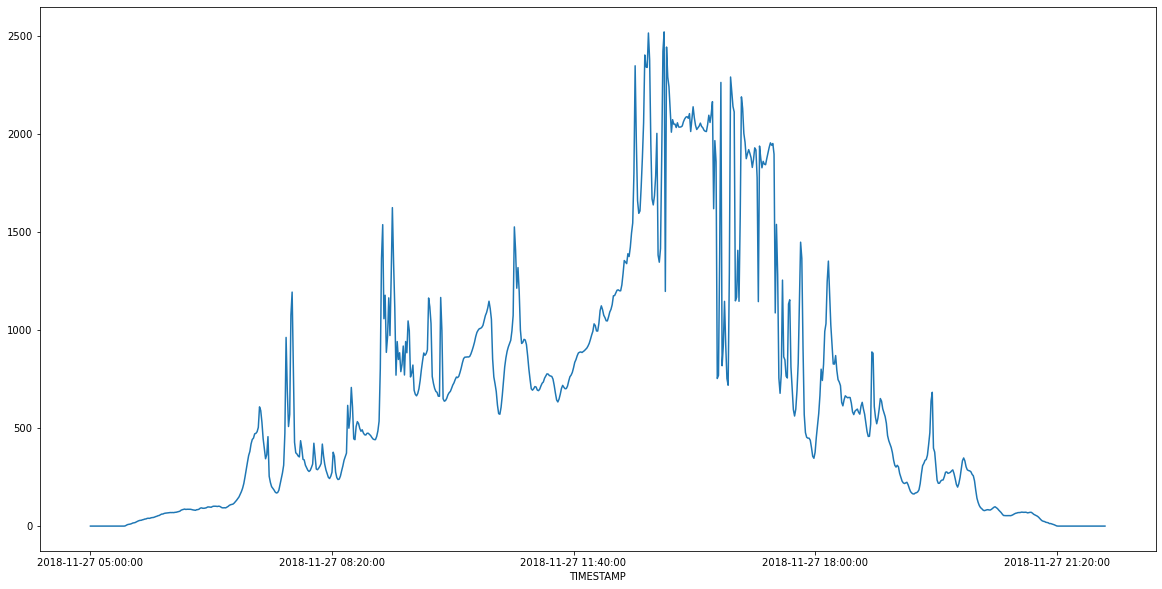

In [219]:
dfCDT.P_in1.loc['2018-11-27 05:00:00':'2018-11-27 22:00:00'].plot( figsize=(20,10))

<AxesSubplot:xlabel='TIMESTAMP'>

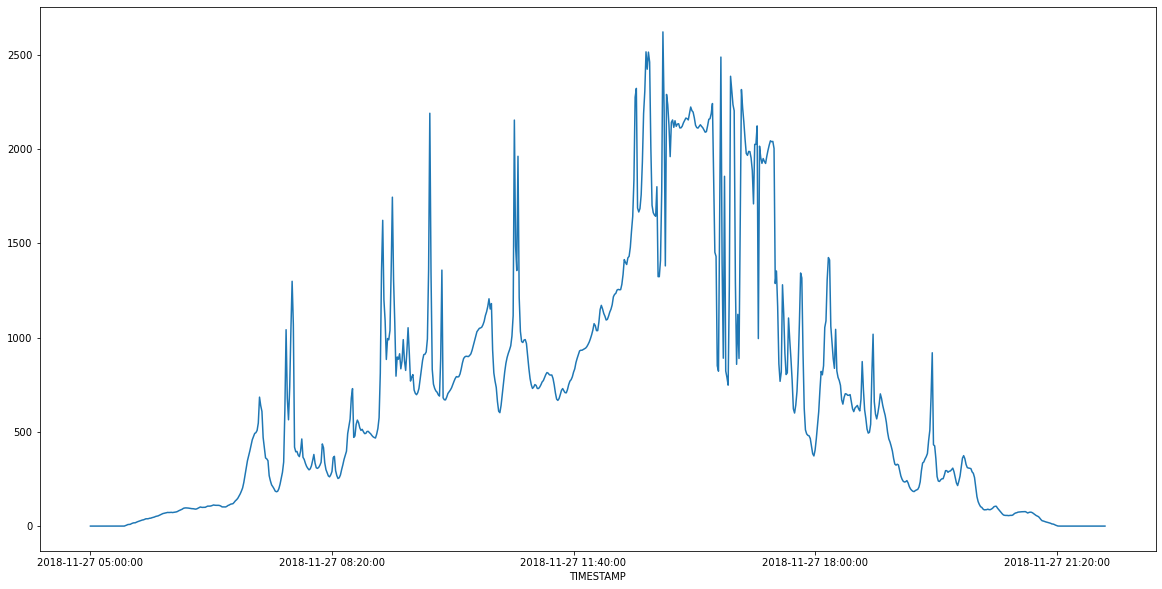

In [220]:
dfCDTA.P_in1.loc['2018-11-27 05:00:00':'2018-11-27 22:00:00'].plot( figsize=(20,10))

<AxesSubplot:xlabel='TIMESTAMP'>

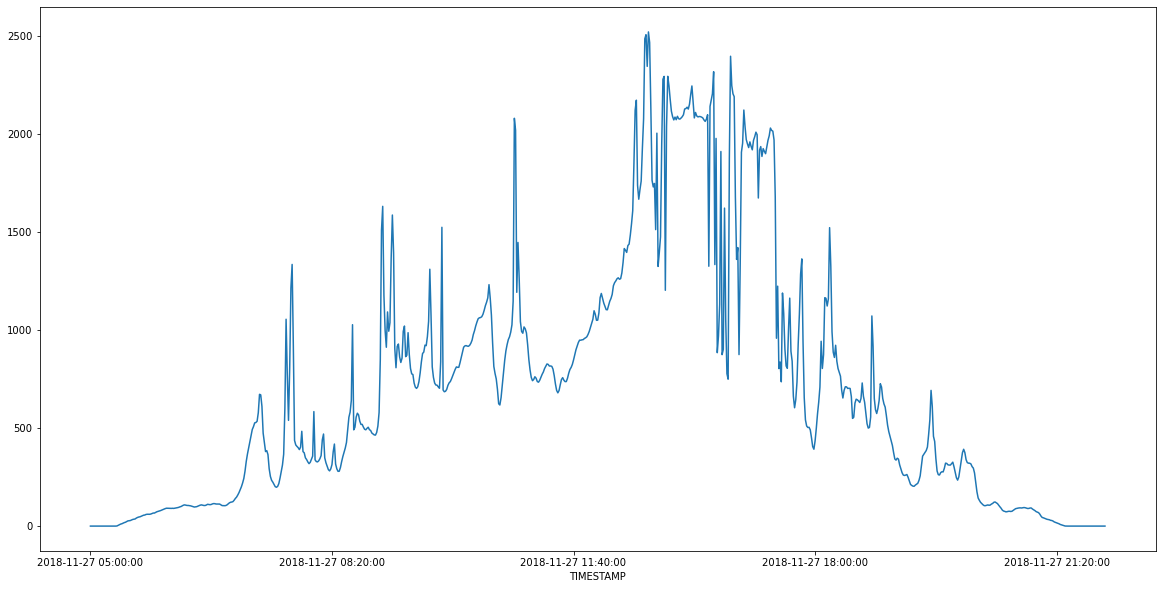

In [221]:
dfPSI.P_in1.loc['2018-11-27 05:00:00':'2018-11-27 22:00:00'].plot( figsize=(20,10))

<AxesSubplot:xlabel='TIMESTAMP'>

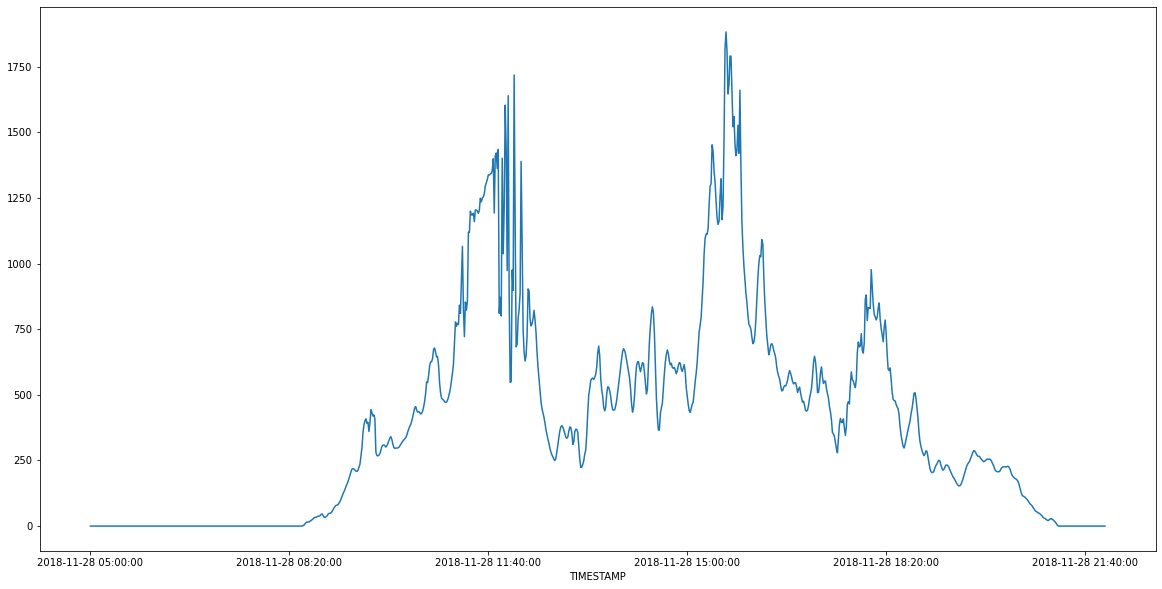

In [222]:
dfCDT.P_in1.loc['2018-11-28 05:00:00':'2018-11-28 22:00:00'].plot( figsize=(20,10))

In [224]:
dfCDTnosync = dfCDT[dfCDT.index < '2018-11-27 00:00:00']
dfCDTsync = dfCDT[dfCDT.index > '2018-11-28 00:00:00']

In [225]:
dfCDTnosync 

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2017-07-04 10:45:00,2193.921,234.6536,6.196396,1434.964,59.98176,1479.344,319.4513,4.700523,0.0,0,0,39.08350,33.51683,5.0
2017-07-04 10:46:00,2193.947,234.8455,6.196651,1439.292,59.99952,1484.001,319.8006,4.718031,0.0,0,0,39.08350,33.30969,5.0
2017-07-04 10:47:00,2193.972,234.7815,6.211050,1441.426,60.00360,1486.006,319.7704,4.747102,0.0,0,0,39.21859,33.41356,5.0
2017-07-04 10:48:00,2193.993,234.6642,6.275977,1450.146,60.00192,1495.513,320.0895,4.776174,0.0,0,0,39.24561,33.30969,5.0
2017-07-04 10:49:00,2194.021,234.4241,6.284834,1456.043,59.98608,1501.076,320.4254,4.810109,0.0,0,0,39.24561,33.15329,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26 23:55:00,0.000,0.0000,0.000000,0.000,0.00000,0.000,0.0000,0.000000,0.0,0,0,0.00000,0.00000,0.0
2018-11-26 23:56:00,0.000,0.0000,0.000000,0.000,0.00000,0.000,0.0000,0.000000,0.0,0,0,0.00000,0.00000,0.0
2018-11-26 23:57:00,0.000,0.0000,0.000000,0.000,0.00000,0.000,0.0000,0.000000,0.0,0,0,0.00000,0.00000,0.0


In [226]:
tzBRA = 'Etc/GMT+3'
tzETC = 'Etc/GMT-0'

In [236]:
dfCDTnosync.index = dfCDTnosync.index.astype(np.datetime64)

ValueError: Passing in 'datetime64' dtype with no precision is not allowed. Please pass in 'datetime64[ns]' instead.

In [243]:
interestCdTe

,E_tot,V_grid,I_grid,P_grid,F_grid,P_in1,V_in1,I_in1,P_in2,V_in2,I_in2,T_inverter,T_booster,R_iso
TIMESTAMP,,,,,,,,,,,,,,
2017-12-01 12:30:00,3431.114,241.1383,11.25111,2680.802,60.01080,2763.066,305.5183,9.118219,0.0,0,0,44.86499,41.75370,5.0
2017-12-01 12:39:00,3431.327,240.4374,11.31708,2688.706,59.98465,2772.897,309.9118,9.263794,0.0,0,0,45.62891,41.29026,5.0
2017-12-01 12:45:00,3431.530,240.3046,11.49484,2726.098,60.00600,2810.410,312.5856,9.199058,0.0,0,0,46.38110,43.25706,5.0
2017-12-23 12:17:00,3665.304,241.3723,11.47580,2733.438,59.99712,2817.395,323.7105,8.925526,0.0,0,0,45.74446,41.77883,5.0
2017-12-23 12:18:00,3665.348,241.2220,11.10244,2681.617,60.00888,2764.553,305.6057,9.537110,0.0,0,0,46.21647,42.74930,5.0
2018-01-11 12:58:00,3819.015,238.6771,11.53664,2693.976,60.00240,2777.295,312.1624,9.184684,0.0,0,0,44.91992,41.48515,5.0
2018-01-31 12:55:00,4020.216,239.9425,11.46572,2732.999,59.93766,2817.524,337.0657,8.596984,0.0,0,0,45.46729,41.92419,5.0
2018-01-31 12:56:00,4020.257,240.1796,11.38444,2732.873,59.95419,2817.395,335.9640,8.648211,0.0,0,0,45.54810,42.60423,5.0
2018-02-03 13:14:00,4050.238,239.2162,11.30841,2669.258,59.98656,2751.812,313.6201,8.981939,0.0,0,0,44.91992,42.94368,5.0
